In [1]:
import numpy as np
import matplotlib.pyplot as plt
import uproot
from scipy.optimize import curve_fit, minimize
from scipy.signal import fftconvolve
plt.rcParams.update({
    'font.size': 13,          # Global default font size
    'axes.titlesize': 16,     # Title font size
    'axes.labelsize': 14,     # Axis label font size
    'xtick.labelsize': 12,    # X tick size
    'ytick.labelsize': 12,    # Y tick size
    'legend.fontsize': 12,    # Legend font size
})

In [2]:
''' Define the convolved function '''

def convolve(x, amp, width, mean, sigma):
    '''Defines a Gaussian convolved with a square wave
    
    x - 1D array of x data, in the data you get from root this would be your bins
    amp - amplitude of the Gaussian
    width - horizontal width of the square wave
    mean - mean of the Gaussian
    sigma - standard deviation of the Gaussian
    
    returns: convolved function '''
    
    #Initialize list for storing a square wave to
    y = np.zeros(x.shape)
    
    # Make a square wave. It is only non-zero for one pulse restricted to -w/2 + m < x < w/2 + m. 
    #At that pulse it has the same height as the Gaussian
    #y[(x > mean - (width-sigma)/2) & (x < mean + (width-sigma)/2)] = amp
    y[(x > mean - (width)/2) & (x < mean + (width)/2)] = amp


    # Create a Gaussian
    gauss = amp* np.exp(-0.5 * ((x - mean)/sigma)**2)
    
    if np.abs(np.sum(gauss)) < 0.001:
        y_conv = 0.0
        
    else:
        # Convolve the Gaussian and square wave
        y_conv = np.convolve(y, gauss, mode='same') / np.sum(gauss) #why the division
        #conv = np.convolve(y, gauss, mode='full')
        #center = len(gauss) // 2
        #y_conv = conv[center : center + len(y)]  # manually align


    return y_conv


def convolve2Gauss(x, amp1, amp2, width, mean1, mean2, sigma1, sigma2):
    '''Defines the sum of two Gaussians convolved with a square wave
    
    x - 1D array of x data, in the data you get from root this would be your bins
    amp - amplitude of the Gaussian
    width - horizontal width of the square wave
    mean - mean of the Gaussian
    sigma - standard deviation of the Gaussian
    
    returns: convolved function '''
    
    #Initialize list for storing a square wave to
    y = np.zeros(x.shape)
    
    # Make a square wave. It is only non-zero for one pulse restricted to -w/2 + m < x < w/2 + m. 
    #At that pulse it has the same height as the Gaussian
    #y[(x > -w/2 + m) & (x < w/2 + m)] = a
    #y[(x > -width/2 + (mean1)/2.0) & (x < width/2 + (mean2)/2.0)] = (amp1+amp2)/2
    #y[(x > -(width-sigma1)/2 + (mean1)) & (x < (width-sigma2)/2 + (mean2))] = (amp1+amp2)/2
    y[(x > (-(width+sigma1)/2 + (mean1))) & (x < ((width+sigma2)/2 + (mean2)))] = (amp1+amp2)/2 #2nd best
    #y[(x > -(width+sigma1)/2) & (x < (width+sigma2)/2)] = (amp1+amp2)/2 #Gives shoulders
    #y[(x > -(width)/2) & (x < (width)/2)] = (amp1+amp2)/2
    #y[(x > (-(width)/2 - (mean1))) & (x < (((width)/2) +mean2))] = (amp1+amp2)/2 #Will fit t58_1458

    #Try one mean only. the mean for each Gaussian is then mean+/-width/2

    # Create a Gaussian
    gauss = (amp1*np.exp(-0.5 * ((x-mean1)/sigma1)**2)) + (amp2*np.exp(-0.5 * ((x-mean2)/sigma2)**2))
    #gauss1 = (amp1*np.exp(-0.5 * ((x-mean1)/sigma1)**2)) + (amp2*np.exp(-0.5 * ((x-mean2)/sigma2)**2))
    #gauss = gauss1/np.sum(gauss1)
    
    #Very bad if paired with the square wave that fits t58_1458 but gets the width to change
    #gauss = (amp1*np.exp(-0.5 * ((x-(-(width)/2 - mean1))/sigma1)**2)) + (amp2*np.exp(-0.5 * ((x-((width)/2 + mean2))/sigma2)**2))

    #gauss = (amp1*np.exp(-0.5 * ((x-(-(width)/2))/sigma1)**2)) + (amp2*np.exp(-0.5 * ((x-((width)/2))/sigma2)**2))

    
    if np.abs(np.sum(gauss)) < 0.001:
        y_conv = 0.0
        
    else:
        # Convolve the Gaussian and square wave
        y_conv = np.convolve(y, gauss, mode='same') / np.sum(gauss) #why the division
        #y_conv = np.convolve(y, gauss, mode='same')
        #y_conv = fftconvolve(y, gauss, mode='same') / np.sum(gauss)

    return y_conv


def convolve2Gauss_3amp(x, amp1, amp2, amp3, width, mean1, mean2, sigma1, sigma2):
    '''Defines the sum of two Gaussians convolved with a square wave
    
    x - 1D array of x data, in the data you get from root this would be your bins
    amp - amplitude of the Gaussian
    width - horizontal width of the square wave
    mean - mean of the Gaussian
    sigma - standard deviation of the Gaussian
    
    returns: convolved function '''
    
    #Initialize list for storing a square wave to
    y = np.zeros(x.shape)
    
    # Make a square wave. It is only non-zero for one pulse restricted to -w/2 + m < x < w/2 + m. 
    #At that pulse it has the same height as the Gaussian
    #y[(x > -w/2 + m) & (x < w/2 + m)] = a
    #y[(x > -width/2 + (mean1)/2.0) & (x < width/2 + (mean2)/2.0)] = (amp1+amp2)/2
    #y[(x > -(width-sigma1)/2 + (mean1)) & (x < (width-sigma2)/2 + (mean2))] = (amp1+amp2)/2
    #y[(x > (-(width+sigma1)/2 + (mean1))) & (x < ((width+sigma2)/2 + (mean2)))] = (amp1+amp2)/2 #2nd best
    y[(x > -(width+sigma1)/2) & (x < (width+sigma2)/2)] = (amp1+amp2)/2 #best
    #y[(x > -(width)/2) & (x < (width)/2)] = amp3/2
    #y[(x > (-(width)/2 - (mean1))) & (x < (((width)/2) +mean2))] = (amp1+amp2)/2 #Will fit t58_1458


    # Create a Gaussian
    gauss = (amp1*np.exp(-0.5 * ((x-mean1)/sigma1)**2)) + (amp2*np.exp(-0.5 * ((x-mean2)/sigma2)**2))
    
    if np.abs(np.sum(gauss)) < 0.001:
        y_conv = 0.0
        
    else:
        # Convolve the Gaussian and square wave
        y_conv = np.convolve(y, gauss, mode='same') / np.sum(gauss) #why the division

    return y_conv


def convolve2Gauss_noMean(x, amp1, amp2, width, sigma1, sigma2):
    '''Defines the sum of two Gaussians convolved with a square wave
    
    x - 1D array of x data, in the data you get from root this would be your bins
    amp - amplitude of the Gaussian
    width - horizontal width of the square wave
    sigma - standard deviation of the Gaussian
    
    returns: convolved function '''
    
    #Initialize list for storing a square wave to
    y = np.zeros(x.shape)
    
    # Make a square wave. It is only non-zero for one pulse restricted to -w/2 + m < x < w/2 + m. 
    #At that pulse it has the same height as the Gaussian
    #y[(x > -(width+sigma1)/2) & (x < (width+sigma2)/2)] = (amp1+amp2)/2
    y[(x > -(width)/2) & (x < (width)/2)] = (amp1+amp2)/2
    


    # Create a Gaussian
    #gauss = amp1*np.exp(-0.5 * ((x-(-(width+sigma1)/2)/sigma1)**2)) + amp2*np.exp(-0.5 * ((x-((width+sigma2)/2))/sigma2)**2)
    gauss = amp1*np.exp(-0.5 * ((x-(-width/2))/sigma1)**2) + amp2*np.exp(-0.5 * ((x-(width/2))/sigma2)**2)

    
    if np.abs(np.sum(gauss)) < 0.001:
        y_conv = 0.0
        
    else:
        # Convolve the Gaussian and square wave
        y_conv = np.convolve(y, gauss, mode='same') / np.sum(gauss) #why the division

    return y_conv


def convolve2Gauss_3param(x, amp, width, sigma):
    '''Defines the sum of two Gaussians convolved with a square wave
    
    x - 1D array of x data, in the data you get from root this would be your bins
    amp - amplitude of the Gaussian
    width - horizontal width of the square wave
    mean - mean of the Gaussian
    sigma - standard deviation of the Gaussian
    
    returns: convolved function '''
    
    #Initialize list for storing a square wave to
    y = np.zeros(x.shape)
    
    # Make a square wave. It is only non-zero for one pulse restricted to -w/2 - s < x < w/2 + s. 
    #At that pulse it has the same height as the Gaussian
    #y[(x > -(width+sigma)/2) & (x < (width+sigma)/2)] = amp
    y[(x > -(width)/2) & (x < (width)/2)] = amp


    # Create a Gaussian
    #gauss = amp*np.exp(-0.5 * ((x-(-(width+sigma)/2))/sigma)**2) + amp*np.exp(-0.5 * ((x-((width+sigma)/2))/sigma)**2)
    gauss = amp*np.exp(-0.5 * ((x-(-(width)/2))/sigma)**2) + amp*np.exp(-0.5 * ((x-((width)/2))/sigma)**2)

        
    if np.abs(np.sum(gauss)) < 0.001:
        y_conv = 0.0
        
    else:
        # Convolve the Gaussian and square wave
        y_conv = np.convolve(y, gauss, mode='same') / (np.sum(gauss)) #why the division

    return y_conv


In [3]:
# how to open a root file in python

with uproot.open("/Users/sidne/DarkLight 2025/output00049.root") as f:
    fileID = "t14ns_1458" # this is the nicest plot, start here then try t58ns_1458
    timeDiff = f["dltdc"][fileID].to_numpy()[0] #y data
    #t14 = f["dltdc"]["t14ns_1458"].to_numpy()[0]
    #t58 = f["dltdc"]["t58ns_1458"].to_numpy()[0]
    #t23 = f["dltdc"]["t23ns_2367"].to_numpy()[0]
    #t67 = f["dltdc"]["t67ns_2367"].to_numpy()[0]
    x_root = f["dltdc"][fileID].to_numpy()[1][0:-1] #x data
    
    timeDiff_firstHalf = timeDiff[0:int(len(timeDiff)/2)]
    timeDiff_lastHalf = timeDiff[int(len(timeDiff)/2):-1]

    
    #Store index where the data is 10% of the max value for that portion of data
    first10pmaxIndex = 0
    last10pmaxIndex = 0
    threshold = 0.15 #Proportion of the max we want to cut at (choose data greater than this proportion of the max)
    foundMax = 0 #Switch to be changed once we find the point crossing the threshold of the max of that part of the data
    i = 0
    j = 0

    while (foundMax == 0) and (i < len(timeDiff_firstHalf)):
        
        if timeDiff_firstHalf[i] > threshold*max(timeDiff_firstHalf):
            first10pmaxIndex = i
            foundMax = 1            
        i = i+1
        
    while (foundMax != 2) and (j < len(timeDiff_lastHalf)):
        
        if timeDiff_lastHalf[len(timeDiff_lastHalf) - 1 - j] > threshold*max(timeDiff_lastHalf):
            last10pmaxIndex = len(timeDiff_lastHalf) - 1 - j
            foundMax = 2            
        j = j+1
            
    #Cut data
    timeDiff_cut = timeDiff[first10pmaxIndex:len(timeDiff_firstHalf)+last10pmaxIndex]
    x_root_cut = x_root[first10pmaxIndex:len(timeDiff_firstHalf)+last10pmaxIndex]
    
    #Calculate y error bars
    y_err = []
    for i in range(len(timeDiff)):
        y_err.append(np.sqrt(timeDiff[i]))
        
    y_err_cut = []
    for i in range(len(timeDiff_cut)):
        y_err_cut.append(np.sqrt(timeDiff_cut[i]))
        
        
    # NEW FOR CHOPPING OFF THE TOP
    peakHeight = max(timeDiff_cut)
    countsChopped_cut = np.zeros(len(timeDiff_cut))
    countsChopped_cut.tolist()
    
    for i in range(len(timeDiff_cut)):
        if timeDiff_cut[i]>((1-threshold)*peakHeight):
            countsChopped_cut[i] = (1-threshold)*peakHeight
        
        else:
            countsChopped_cut[i] = timeDiff_cut[i]
                  
#plt.plot(x_root_cut,timeDiff_cut)


In [4]:
'''Calculate initial guess'''

def getHalfHeight(yList):
    #Store the index where the function's height is half of the peak's height
    halfwayHeight = 0.0 #Initialize variable for the data point y-value that is half of the peak height
    halfwayIndex = 0 #Initialize variable for the index of the left point that is half of the peak height
    while halfwayHeight < 0.5*np.max(yList):
        halfwayHeight = yList[halfwayIndex]
        halfwayIndex += 1
    return halfwayIndex

def getInitialGuess(bins, data):
    dataList = data.tolist() #Convert np array to list
    
    #Data's amplitude
    amp = max(data)
    
    #Store the index where the function's height is half of the peak's height
    halfwayIndex = getHalfHeight(data)
    
    #Define the width as the difference between points where the data is half of its maximum value
    width = bins[dataList.index(amp) + np.abs(dataList.index(amp) - halfwayIndex)] - bins[halfwayIndex]    
    
    mean = np.average(bins, weights=data)
    
    sigma = (bins[dataList.index(amp) + np.abs(dataList.index(amp) - halfwayIndex)] - bins[halfwayIndex])/10.0
    
    return [amp, width, mean, sigma]



def getInitialGuess2(bins, data):
    '''Get initial guess for two Gaussians convolved with a square wave'''
    
    dataList = data.tolist() #Convert np array to list

    amp1 = max(data[0:int(len(dataList)/2)])
    amp2 = max(data[int(len(dataList)/2):-1])
    
    #Data's amplitude
    dataMax = max(data)
        
    #Store the index where the function's height is half of the peak's height
    halfwayIndex = getHalfHeight(data)
    
    #Define the width as the difference between points where the data is half of its maximum value
    width = bins[dataList.index(dataMax) + np.abs(dataList.index(dataMax) - halfwayIndex)] - bins[halfwayIndex]
    
    mean1 = np.average(bins, weights=data)
    mean2 = -mean1
    
    sigma1 = (bins[dataList.index(dataMax) + np.abs(dataList.index(dataMax) - halfwayIndex)] - bins[halfwayIndex])/10.0
    sigma2 = sigma1
    
    
    return [amp1, amp2, width, mean1, mean2, sigma1, sigma2]

def getInitialGuess2_3amp(bins, data):
    '''Get initial guess for two Gaussians convolved with a square wave'''
    
    dataList = data.tolist() #Convert np array to list

    amp1 = max(data[0:int(len(dataList)/2)])
    amp2 = max(data[int(len(dataList)/2):-1])
    
    #Data's amplitude
    dataMax = max(data)
        
    #Store the index where the function's height is half of the peak's height
    halfwayIndex = getHalfHeight(data)
    
    #Define the width as the difference between points where the data is half of its value at its max
    width = bins[dataList.index(dataMax) + np.abs(dataList.index(dataMax) - halfwayIndex)] - bins[halfwayIndex]
    
    mean1 = np.average(bins, weights=data)
    mean2 = -mean1
    
    sigma1 = (bins[dataList.index(dataMax) + np.abs(dataList.index(dataMax) - halfwayIndex)] - bins[halfwayIndex])/10.0
    sigma2 = sigma1
    
    
    return [amp1, amp2, max(dataList), width, mean1, mean2, sigma1, sigma2]


def getInitialGuess2_noMean(bins, data):
    '''Get initial guess for two Gaussians convolved with a square wave'''
    
    dataList = data.tolist() #Convert np array to list

    amp1 = max(data[0:int(len(dataList)/2)])
    amp2 = max(data[int(len(dataList)/2):-1])
    
    #Data's amplitude
    dataMax = max(data)
        
    #Store the index where the function's height is half of the peak's height
    halfwayIndex = getHalfHeight(data)
    
    #Define the width as the difference between points where the data is half of its value at its max
    width = bins[dataList.index(dataMax) + np.abs(dataList.index(dataMax) - halfwayIndex)] - bins[halfwayIndex]
    
    sigma1 = (bins[dataList.index(dataMax) + np.abs(dataList.index(dataMax) - halfwayIndex)] - bins[halfwayIndex])/10.0
    sigma2 = sigma1
    
    
    return [amp1, amp2, width, sigma1, sigma2]


def getInitialGuess2_3param(bins, data):
    '''Get initial guess for two Gaussians convolved with a square wave'''
    
    dataList = data.tolist() #Convert np array to list
    
    #Data's amplitude
    dataMax = max(data)
        
    #Store the index where the function's height is half of the peak's height
    halfwayIndex = getHalfHeight(data)
    
    #Define the width as the difference between points where the data is half of its value at its max
    width = bins[dataList.index(dataMax) + np.abs(dataList.index(dataMax) - halfwayIndex)] - bins[halfwayIndex]
    
    sigma1 = (bins[dataList.index(dataMax) + np.abs(dataList.index(dataMax) - halfwayIndex)] - bins[halfwayIndex])/10.0
    sigma2 = sigma1
    
    
    return [dataMax, width, sigma1]


#Define initial guess for two Gaussians convolved with a square wave
p0_1Gauss = getInitialGuess(x_root, timeDiff)
p0_2Gauss = getInitialGuess2(x_root, timeDiff)
p0_noMean = getInitialGuess2_noMean(x_root, timeDiff)
p0_3param = getInitialGuess2_3param(x_root, timeDiff)
p0_3amp = getInitialGuess2_3amp(x_root, timeDiff)

print(p0_1Gauss)
print(p0_2Gauss)

[2742.0, 2.6000000000000014, 0.05621481518168225, 0.2600000000000001]
[2673.0, 2742.0, 2.6000000000000014, 0.05621481518168225, -0.05621481518168225, 0.2600000000000001, 0.2600000000000001]


In [5]:
''' Fit using Scipy.optimize.curvefit (least squares) '''

popt_1Gauss, pcov_1Gauss, infoDict_1Gauss, mesg_1Gauss, ier_1Gauss = curve_fit(convolve, x_root_cut, timeDiff_cut, p0=p0_1Gauss, full_output=True)
popt_2Gauss, pcov_2Gauss, infoDict_2Gauss, mesg_2Gauss, ier_2Gauss = curve_fit(convolve2Gauss, x_root_cut, timeDiff_cut, p0=p0_2Gauss, full_output=True)
popt_noMean, pcov_noMean, infoDict_noMean, mesg_noMean, ier_noMean = curve_fit(convolve2Gauss_noMean, x_root_cut, timeDiff_cut, p0=p0_noMean, full_output=True)
popt_3param, pcov_3param, infoDict_3param, mesg_3param, ier_3param = curve_fit(convolve2Gauss_3param, x_root_cut, timeDiff_cut, p0=p0_3param, full_output=True)
popt_3amp, pcov_3amp, infoDict_3amp, mesg_3amp, ier_3amp = curve_fit(convolve2Gauss_3amp, x_root_cut, timeDiff_cut, p0=p0_3amp, full_output=True)


popt_chopped_cut, pcov_chopped_cut, infoDict_chopped_cut, mesg_chopped_cut, ier_chopped_cut = curve_fit(convolve, x_root_cut, countsChopped_cut, p0=p0_1Gauss, full_output=True)
popt_2chopped_cut, pcov_2chopped_cut, infoDict_2chopped_cut, mesg_2chopped_cut, ier_2chopped_cut = curve_fit(convolve2Gauss, x_root_cut, countsChopped_cut, p0=p0_2Gauss, full_output=True)


print(popt_1Gauss)
print(popt_2Gauss)
#print(popt_noMean)
#print(popt_3param)
#print(popt_3amp)

[2.52357881e+03 2.60000000e+00 2.70408070e-02 4.35969405e-01]
[2.54188795e+03 2.55869560e+03 2.60000000e+00 2.54196796e-01
 2.32282373e-02 7.08393573e-01 7.42869259e-01]


C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


x comparison: -1.4000000000000004 -1.4000000000000004
y comparison: 575.300683009798 460.7935311101564
x values
[-1.4 -1.3 -1.2 -1.1 -1.  -0.9 -0.8 -0.7 -0.6 -0.5 -0.4 -0.3 -0.2 -0.1
  0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3
  1.4]


[ 441.   636.   917.  1171.  1584.  1850.  2089.  2273.  2330.7 2330.7
 2330.7 2330.7 2330.7 2330.7 2330.7 2330.7 2330.7 2330.7 2330.7 2330.7
 2330.7 2330.7 2327.  2229.  1834.  1544.  1199.   937.   658. ]
Fitting for 2 amplitudes, sigmas, means and one width
Cut: 2533
Full: 2444

 Fitting for 2 amplitudes, sigmas and one width, no mean
Cut: 2696
Full: 1306

 Fitting with one Gaussian
Cut: 2518
Full: 2516


Text(0.5, 1.0, 'Gaussians convolved with square wave')

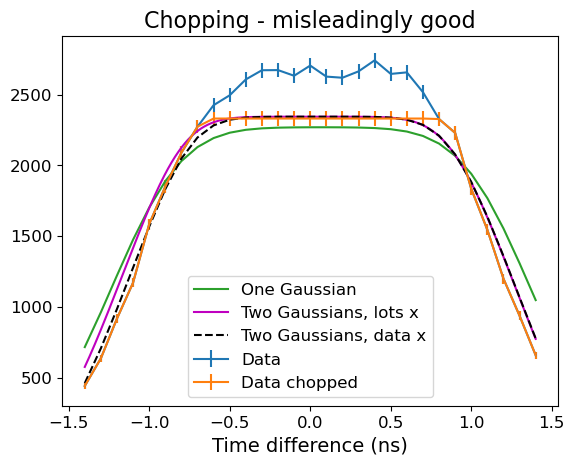

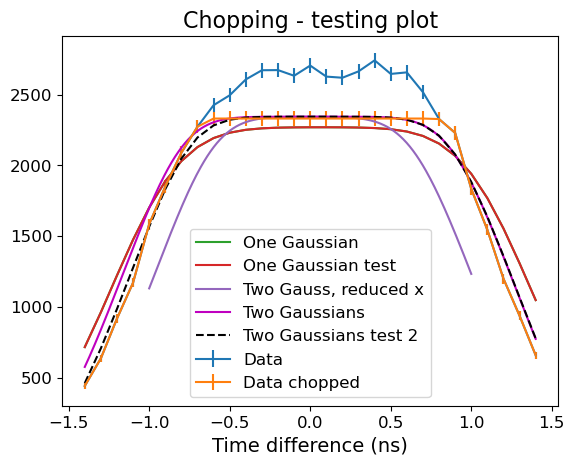

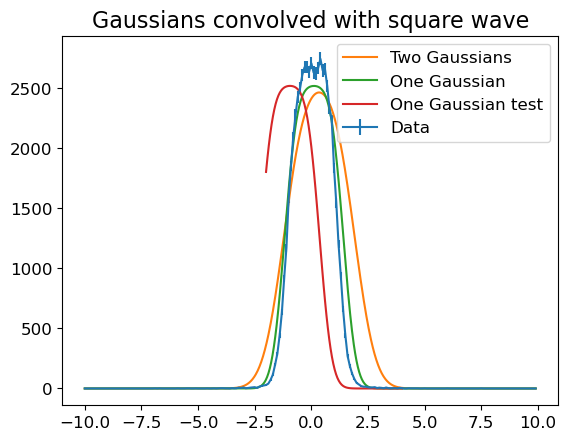

In [6]:
''' Plotting different fit functions against each other and the data '''

#plt.errorbar(x_root_cut, timeDiff_cut, yerr=y_err_cut, label='Data')
#plt.plot(x_root_cut, convolve2Gauss(x_root_cut, *popt_2Gauss),label="Two Gaussians")
#plt.plot(x_root_cut, convolve(x_root_cut, *popt_1Gauss),label="One Gaussian")
#plt.plot(x_root_cut, convolve2Gauss_noMean(x_root_cut, *popt_noMean),label="Two Gaussians no mean")
#plt.plot(x_root_cut, convolve2Gauss_3param(x_root_cut, *popt_3param),label="Two Gaussians 3 param")
#plt.plot(x_root_cut, convolve2Gauss_3amp(x_root_cut, *popt_3amp),label="Two Gaussians 3 amp")
#plt.legend()
#plt.title("Gaussians convolved with square wave")

#Chopping plot
x_root_cut_lots = np.linspace(x_root_cut[0], x_root_cut[-1], 500)
print("x comparison:", x_root_cut_lots[0], x_root_cut[0])
print("y comparison:", convolve2Gauss(x_root_cut_lots, *popt_2chopped_cut).tolist()[0], convolve2Gauss(x_root_cut, *popt_2chopped_cut).tolist()[0])
# PROB

# Good chopping plot
plt.figure()
plt.errorbar(x_root_cut, timeDiff_cut, yerr=y_err_cut, label='Data')
plt.errorbar(x_root_cut, countsChopped_cut, yerr=y_err_cut, label='Data chopped')
plt.plot(x_root_cut, convolve(x_root_cut, *popt_chopped_cut),label="One Gaussian")
plt.plot(x_root_cut_lots, convolve2Gauss(x_root_cut_lots, *popt_2chopped_cut),color='m',label="Two Gaussians, lots x")
plt.plot(x_root_cut, convolve2Gauss(x_root_cut, *popt_2chopped_cut),'k--',label="Two Gaussians, data x")
plt.title("Chopping - misleadingly good")
plt.xlabel("Time difference (ns)")
plt.legend()



# Testing chopping plot that shows the problems when you plot over a different x range than what stuff was
# calculated over
plt.figure()
plt.errorbar(x_root_cut, timeDiff_cut, yerr=y_err_cut, label='Data')
plt.errorbar(x_root_cut, countsChopped_cut, yerr=y_err_cut, label='Data chopped')
plt.plot(x_root_cut, convolve(x_root_cut, *popt_chopped_cut),label="One Gaussian")
plt.plot(x_root_cut, convolve(x_root_cut, *popt_chopped_cut),label="One Gaussian test")
plt.plot(np.linspace(-1.0,1.0,300), convolve2Gauss(np.linspace(-1.0,1.0,300), *popt_2chopped_cut),label="Two Gauss, reduced x")
plt.plot(x_root_cut_lots, convolve2Gauss(x_root_cut_lots, *popt_2chopped_cut),color='m',label="Two Gaussians")
plt.plot(x_root_cut, convolve2Gauss(x_root_cut, *popt_2chopped_cut),'k--',label="Two Gaussians test 2")
plt.title("Chopping - testing plot")
plt.xlabel("Time difference (ns)")
plt.legend()
print("x values")
print(x_root_cut)
print("\n")
print(countsChopped_cut)


###  TESTING  ###
x_lots = np.linspace(x_root[0],x_root[-1],1000)
#x_lots_cut = np.linspace(x_root_cut[0],x_root_cut[-1],1000)
popt_test = (popt_2Gauss[0],popt_2Gauss[1],2.4, popt_2Gauss[3], popt_2Gauss[4], 0.8,0.8)

print("Fitting for 2 amplitudes, sigmas, means and one width")
print("Cut:", int(max(convolve2Gauss(x_root_cut, *popt_2Gauss))))
print("Full:", int(max(convolve2Gauss(x_root, *popt_2Gauss))))

print("\n Fitting for 2 amplitudes, sigmas and one width, no mean")
print("Cut:", int(max(convolve2Gauss_noMean(x_root_cut, *popt_noMean))))
print("Full:", int(max(convolve2Gauss_noMean(x_root, *popt_noMean))))

print("\n Fitting with one Gaussian")
print("Cut:", int(max(convolve(x_root_cut, *popt_1Gauss))))
print("Full:", int(max(convolve(x_root, *popt_1Gauss))))

#Plot the data and the fit over the full data range using the fit parameters from fitting over the restricted range
plt.figure()
plt.errorbar(x_root, timeDiff, yerr=y_err, label='Data')
plt.plot(x_lots, convolve2Gauss(x_lots, *popt_2Gauss),label="Two Gaussians")
plt.plot(x_lots, convolve(x_lots, *popt_1Gauss),label="One Gaussian")
plt.plot(np.linspace(-2,4,100), convolve(np.linspace(-2,4,100), *popt_1Gauss),label="One Gaussian test")
#plt.plot(x_lots, convolve2Gauss(x_lots, *popt_test), 'g', label="Tester")
#plt.plot(x_lots, convolve2Gauss_3amp(x_lots, *popt_3amp), 'purple', label="Tester")
plt.legend()
plt.title("Gaussians convolved with square wave")

#print(popt_1Gauss)

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def plot_all_fits(x, y, yerr, models, x_dense=None, title="Fit Comparison"):
    plt.figure(figsize=(10, 6))
    plt.errorbar(x, y, yerr=yerr, fmt='o', markersize=3, label='Data', alpha=0.7)

    for label, func, popt in models:
        x_plot = x_dense if x_dense is not None else x
        plt.plot(x_plot, func(x_plot, *popt), label=label)

    plt.axvline(x[0], color='gray', linestyle='--', alpha=0.4)
    plt.axvline(x[-1], color='gray', linestyle='--', alpha=0.4)
    plt.xlabel("Time difference (ns)")
    plt.ylabel("Counts")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_residuals(x, y, models, title="Residuals"):
    plt.figure(figsize=(10, 4))
    for label, func, popt in models:
        y_fit = func(x, *popt)
        residuals = y - y_fit
        plt.plot(x, residuals, label=label)
    plt.axhline(0, color='black', linewidth=1)
    plt.xlabel("Time difference (ns)")
    plt.ylabel("Residual (Data - Fit)")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_chopped_comparison(x, y, y_chopped, yerr, func, popt_raw, popt_chopped):
    plt.figure(figsize=(10, 6))
    plt.errorbar(x, y, yerr=yerr, fmt='o', label="Raw Data", alpha=0.5)
    plt.errorbar(x, y_chopped, yerr=yerr, fmt='o', label="Chopped Data", alpha=0.5)
    plt.plot(x, func(x, *popt_raw), label="Fit (Raw)", linewidth=2)
    plt.plot(x, func(x, *popt_chopped), label="Fit (Chopped)", linestyle='--', linewidth=2)
    plt.xlabel("Time difference (ns)")
    plt.ylabel("Counts")
    plt.title("Chopped vs Raw Fit")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_extrapolated_fit(x_full, y_full, yerr_full, x_dense, models_cut, title="Extrapolated Fit Diagnostic"):
    plt.figure(figsize=(10, 6))
    plt.errorbar(x_full, y_full, yerr=yerr_full, fmt='o', markersize=3, label='Full Data', alpha=0.6)

    for label, func, popt in models_cut:
        plt.plot(x_dense, func(x_dense, *popt), label=f"{label} (fit on cut)")

    plt.xlabel("Time difference (ns)")
    plt.ylabel("Counts")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()


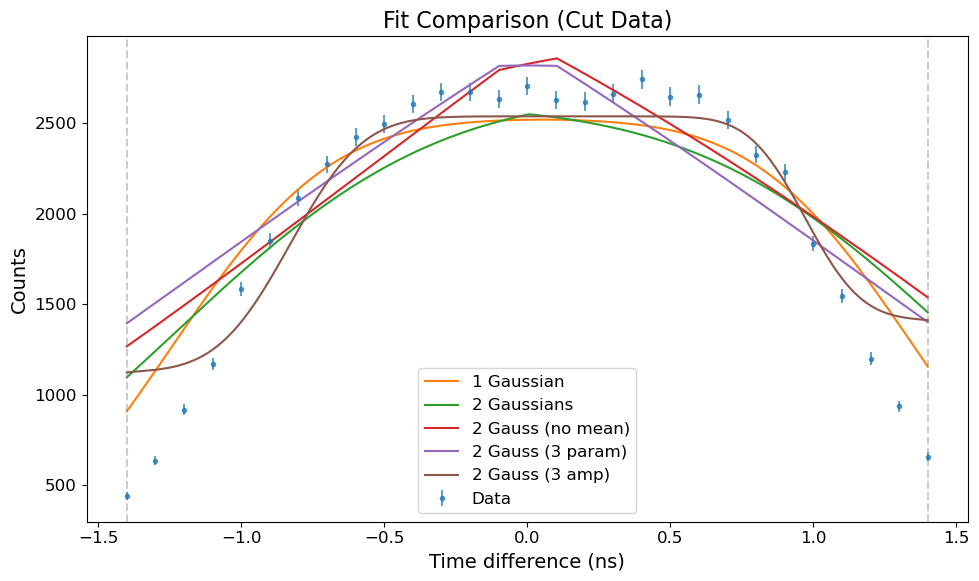

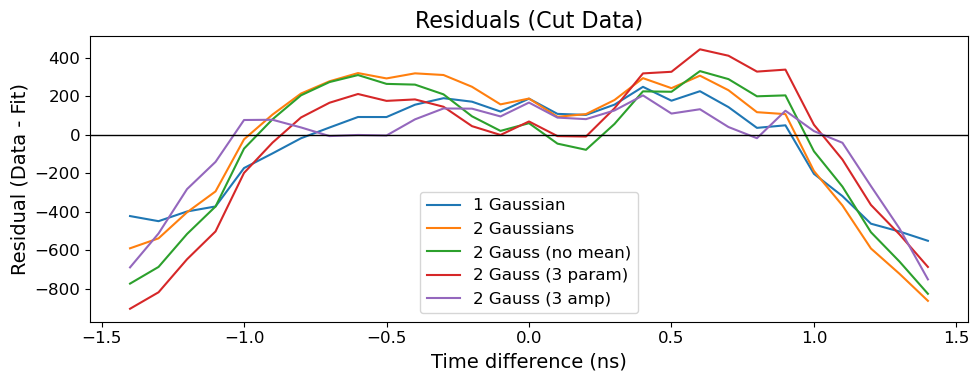

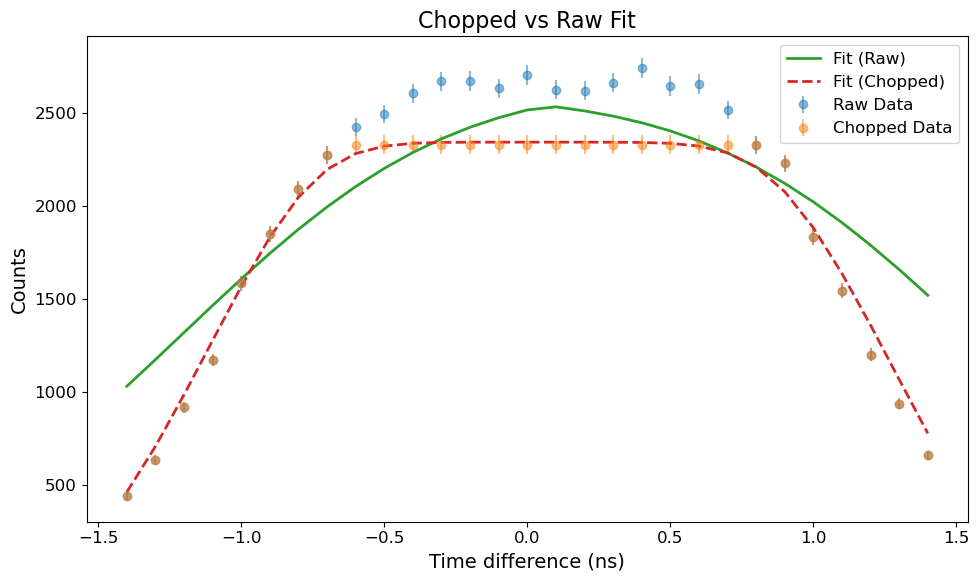

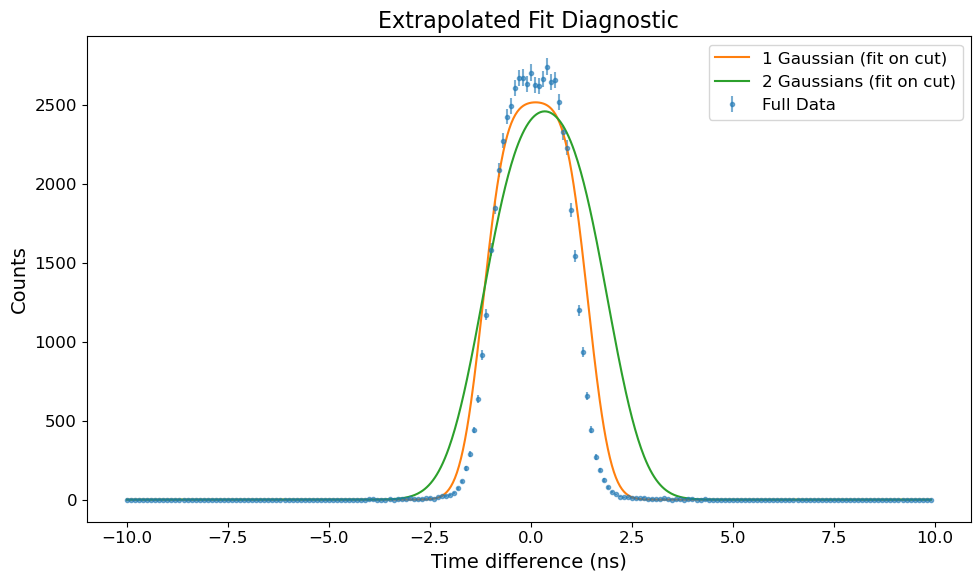

In [8]:
# Dense x values for plotting
x_dense_cut = np.linspace(x_root_cut[0], x_root_cut[-1], 500)
x_dense_full = np.linspace(x_root[0], x_root[-1], 800)

models_cut = [
    ("1 Gaussian", convolve, popt_1Gauss),
    ("2 Gaussians", convolve2Gauss, popt_2Gauss),
]

models_all = models_cut + [
    ("2 Gauss (no mean)", convolve2Gauss_noMean, popt_noMean),
    ("2 Gauss (3 param)", convolve2Gauss_3param, popt_3param),
    ("2 Gauss (3 amp)", convolve2Gauss_3amp, popt_3amp),
]

# Core comparisons
plot_all_fits(x_root_cut, timeDiff_cut, y_err_cut, models_all, x_dense_cut, "Fit Comparison (Cut Data)")
plot_residuals(x_root_cut, timeDiff_cut, models_all, title="Residuals (Cut Data)")
plot_chopped_comparison(x_root_cut, timeDiff_cut, countsChopped_cut, y_err_cut, convolve2Gauss, popt_2Gauss, popt_2chopped_cut)

# Extrapolation check — models trained on cut data
plot_extrapolated_fit(x_root, timeDiff, y_err, x_dense_full, models_cut, "Extrapolated Fit Diagnostic")


In [9]:
from scipy.signal import fftconvolve
import numpy as np

def convolve_fixed_1gauss(x, amp, width, mean, sigma):
    """
    Convolve a square wave (height=amp, width=width, centered at mean)
    with a normalized Gaussian (centered at mean, std=sigma).
    """
    dx = x[1] - x[0]  # assumes uniform spacing

    # Square wave definition
    square = np.zeros_like(x)
    square[(x > mean - width / 2) & (x < mean + width / 2)] = amp

    # Gaussian definition (normalized)
    gauss = np.exp(-0.5 * ((x - mean) / sigma) ** 2)
    gauss /= np.sum(gauss)  # unit area

    # Convolution (same output size as input)
    y_conv = fftconvolve(square, gauss, mode='same')

    return y_conv


In [10]:
from scipy.signal import fftconvolve
import numpy as np

def convolve_fixed_2gauss(x, amp1, amp2, width, mean1, mean2, sigma1, sigma2):
    """
    Sum of two Gaussians convolved with a square wave:
    - Square wave is centered between mean1 and mean2
    - Gaussians are centered at mean1 and mean2
    """
    dx = x[1] - x[0]  # assumes uniform spacing

    # Center square wave between the two Gaussians
    center = 0.5 * (mean1 + mean2)
    square = np.zeros_like(x)
    square[(x > center - width / 2) & (x < center + width / 2)] = (amp1 + amp2) / 2

    # Two Gaussians (not normalized — will normalize combined kernel)
    gauss1 = amp1 * np.exp(-0.5 * ((x - mean1) / sigma1) ** 2)
    gauss2 = amp2 * np.exp(-0.5 * ((x - mean2) / sigma2) ** 2)
    gauss_sum = gauss1 + gauss2

    # Normalize to unit area
    gauss_sum /= np.sum(gauss_sum)

    # Convolution
    y_conv = fftconvolve(square, gauss_sum, mode='same')

    return y_conv


In [11]:
def get_initial_guess_2gauss(x, y):
    y = np.array(y)
    x = np.array(x)

    # Split data in half and find peaks
    mid = len(x) // 2
    amp1 = np.max(y[:mid])
    amp2 = np.max(y[mid:])

    idx1 = np.argmax(y[:mid])
    idx2 = mid + np.argmax(y[mid:])

    mean1 = x[idx1]
    mean2 = x[idx2]

    # Estimate width from half-max of the overall signal
    amp_total = np.max(y)
    half_max = amp_total / 2
    above_half = np.where(y >= half_max)[0]
    if len(above_half) < 2:
        width = (x[-1] - x[0]) / 4
    else:
        width = x[above_half[-1]] - x[above_half[0]]

    sigma1 = width / 10.0
    sigma2 = width / 10.0

    return [amp1, amp2, width, mean1, mean2, sigma1, sigma2]


In [12]:
def get_initial_guess_1gauss(x, y):
    y = np.array(y)
    x = np.array(x)

    amp = np.max(y)
    mean = np.average(x, weights=y)

    half_max = amp / 2
    above_half = np.where(y >= half_max)[0]

    if len(above_half) < 2:
        width = (x[-1] - x[0]) / 4  # fallback
    else:
        width = x[above_half[-1]] - x[above_half[0]]

    sigma = width / 10.0

    return [amp, width, mean, sigma]


In [13]:
def report_fit_quality(x, y, yerr, func, popt, label=""):
    y_fit = func(x, *popt)
    residuals = y - y_fit

    chi2 = np.sum((residuals / yerr) ** 2)
    dof = len(y) - len(popt)
    chi2_red = chi2 / dof

    print(f"\n--- Fit Report: {label} ---")
    if len(popt) == 4:  # 1-Gauss
        print(f"  σ (timing resolution): {popt[3]:.4f}")
    elif len(popt) == 7:  # 2-Gauss
        print(f"  σ₁: {popt[5]:.4f}")
        print(f"  σ₂: {popt[6]:.4f}")
    print(f"  χ²: {chi2:.2f}")
    print(f"  χ² / ν (reduced): {chi2_red:.2f}")

    return chi2, chi2_red



In [14]:
from scipy.optimize import curve_fit

# Initial guess
p0_1gauss = get_initial_guess_1gauss(x_root_cut, timeDiff_cut)
p0_1gauss_chopped = get_initial_guess_1gauss(x_root_cut, countsChopped_cut)

# Fit
popt_1gauss, _ = curve_fit(convolve_fixed_1gauss, x_root_cut, timeDiff_cut, p0=p0_1gauss)
popt_1gauss_chopped, _ = curve_fit(convolve_fixed_1gauss, x_root_cut, countsChopped_cut, p0=p0_1gauss_chopped)
# Initial guesses
p0_2gauss = get_initial_guess_2gauss(x_root_cut, timeDiff_cut)
p0_2gauss_chopped = get_initial_guess_2gauss(x_root_cut, countsChopped_cut)

# Fit
popt_2gauss, _ = curve_fit(convolve_fixed_2gauss, x_root_cut, timeDiff_cut, p0=p0_2gauss)
popt_2gauss_chopped, _ = curve_fit(convolve_fixed_2gauss, x_root_cut, countsChopped_cut, p0=p0_2gauss_chopped)
report_fit_quality(x_root_cut, timeDiff_cut, y_err_cut, convolve_fixed_1gauss, popt_1gauss, label="1-Gauss Raw")
#Fit quality
report_fit_quality(x_root_cut, countsChopped_cut, y_err_cut, convolve_fixed_1gauss, popt_1gauss_chopped, label="1-Gauss Chopped")

report_fit_quality(x_root_cut, timeDiff_cut, y_err_cut, convolve_fixed_2gauss, popt_2gauss, label="2-Gauss Raw")
report_fit_quality(x_root_cut, countsChopped_cut, y_err_cut, convolve_fixed_2gauss, popt_2gauss_chopped, label="2-Gauss Chopped")



--- Fit Report: 1-Gauss Raw ---
  σ (timing resolution): 0.3544
  χ²: 230.91
  χ² / ν (reduced): 9.24

--- Fit Report: 1-Gauss Chopped ---
  σ (timing resolution): 0.2659
  χ²: 127.51
  χ² / ν (reduced): 5.10

--- Fit Report: 2-Gauss Raw ---
  σ₁: 0.2906
  σ₂: 0.3337
  χ²: 195.54
  χ² / ν (reduced): 8.89

--- Fit Report: 2-Gauss Chopped ---
  σ₁: -0.0011
  σ₂: 0.4555
  χ²: 469.85
  χ² / ν (reduced): 21.36


(469.84619237851376, 21.35664510811426)

In [15]:
import matplotlib.pyplot as plt
import numpy as np

def plot_chopped_vs_raw_dual(
    x, y_raw, y_chopped, yerr,
    func1, popt1_raw, popt1_chop,
    func2, popt2_raw, popt2_chop
):
    fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

    ### --- Single Gaussian Fit --- ###
    axs[0].errorbar(x, y_raw, yerr=yerr, fmt='o', markersize=4, label="Raw Data", alpha=0.6)
    axs[0].errorbar(x, y_chopped, yerr=yerr, fmt='o', markersize=4, label="Chopped Data", alpha=0.6)

    axs[0].plot(x, func1(x, *popt1_raw), label="Fit on Raw", linewidth=2, color='tab:blue')
    axs[0].plot(x, func1(x, *popt1_chop), label="Fit on Chopped", linestyle='--', linewidth=2, color='tab:red')

    axs[0].set_title("1 Gaussian Convolved")
    axs[0].set_xlabel("Time difference (ns)")
    axs[0].set_ylabel("Counts")
    axs[0].grid(True, linestyle=':', alpha=0.3)
    axs[0].legend()

    ### --- Two Gaussian Fit --- ###
    axs[1].errorbar(x, y_raw, yerr=yerr, fmt='o', markersize=4, label="Raw Data", alpha=0.6)
    axs[1].errorbar(x, y_chopped, yerr=yerr, fmt='o', markersize=4, label="Chopped Data", alpha=0.6)

    axs[1].plot(x, func2(x, *popt2_raw), label="Fit on Raw", linewidth=2, color='tab:blue')
    axs[1].plot(x, func2(x, *popt2_chop), label="Fit on Chopped", linestyle='--', linewidth=2, color='tab:red')

    axs[1].set_title("2 Gaussians Convolved")
    axs[1].set_xlabel("Time difference (ns)")
    axs[1].grid(True, linestyle=':', alpha=0.3)
    axs[1].legend()

    fig.suptitle("Chopped vs Raw Fit: 1 Gauss vs 2 Gauss", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    ### --- Fit Quality Reporting --- ###
    def fit_stats(x, y, yerr, func, popt):
        y_fit = func(x, *popt)
        residuals = y - y_fit
        chi2 = np.sum((residuals / yerr) ** 2)
        dof = len(y) - len(popt)
        chi2_red = chi2 / dof
        return chi2, chi2_red

    chi2_1_raw, chi2red_1_raw = fit_stats(x, y_raw, yerr, func1, popt1_raw)
    chi2_1_chop, chi2red_1_chop = fit_stats(x, y_chopped, yerr, func1, popt1_chop)
    chi2_2_raw, chi2red_2_raw = fit_stats(x, y_raw, yerr, func2, popt2_raw)
    chi2_2_chop, chi2red_2_chop = fit_stats(x, y_chopped, yerr, func2, popt2_chop)

    print("\n--- Fit Results ---")
    print("1 Gaussian:")
    print(f"  Raw     | σ = {popt1_raw[3]:.4f}, χ² = {chi2_1_raw:.2f}, χ²/ν = {chi2red_1_raw:.2f}")
    print(f"  Chopped | σ = {popt1_chop[3]:.4f}, χ² = {chi2_1_chop:.2f}, χ²/ν = {chi2red_1_chop:.2f}")

    print("\n2 Gaussians:")
    print(f"  Raw     | σ₁ = {popt2_raw[5]:.4f}, σ₂ = {popt2_raw[6]:.4f}, χ² = {chi2_2_raw:.2f}, χ²/ν = {chi2red_2_raw:.2f}")
    print(f"  Chopped | σ₁ = {popt2_chop[5]:.4f}, σ₂ = {popt2_chop[6]:.4f}, χ² = {chi2_2_chop:.2f}, χ²/ν = {chi2red_2_chop:.2f}")


def plot_residuals_dual(
    x, y_raw, y_chopped, yerr,
    func1, popt1_raw, popt1_chop,
    func2, popt2_raw, popt2_chop
):
    fig, axs = plt.subplots(2, 2, figsize=(14, 8), sharex=True)

    ### --- Residuals: 1-Gauss Raw ---
    y_fit_1_raw = func1(x, *popt1_raw)
    residuals_1_raw = y_raw - y_fit_1_raw
    axs[0, 0].errorbar(x, residuals_1_raw, yerr=yerr, fmt='o', markersize=3, label='Raw Residuals')
    axs[0, 0].axhline(0, color='black', linestyle='--')
    axs[0, 0].set_title("1 Gaussian Residuals (Raw)")
    axs[0, 0].set_ylabel("Residuals (Data - Fit)")
    axs[0, 0].grid(True, linestyle=':')

    ### --- Residuals: 1-Gauss Chopped ---
    y_fit_1_chop = func1(x, *popt1_chop)
    residuals_1_chop = y_chopped - y_fit_1_chop
    axs[1, 0].errorbar(x, residuals_1_chop, yerr=yerr, fmt='o', markersize=3, color='orange', label='Chopped Residuals')
    axs[1, 0].axhline(0, color='black', linestyle='--')
    axs[1, 0].set_title("1 Gaussian Residuals (Chopped)")
    axs[1, 0].set_xlabel("Time difference (ns)")
    axs[1, 0].set_ylabel("Residuals (Data - Fit)")
    axs[1, 0].grid(True, linestyle=':')

    ### --- Residuals: 2-Gauss Raw ---
    y_fit_2_raw = func2(x, *popt2_raw)
    residuals_2_raw = y_raw - y_fit_2_raw
    axs[0, 1].errorbar(x, residuals_2_raw, yerr=yerr, fmt='o', markersize=3, label='Raw Residuals')
    axs[0, 1].axhline(0, color='black', linestyle='--')
    axs[0, 1].set_title("2 Gaussian Residuals (Raw)")
    axs[0, 1].grid(True, linestyle=':')

    ### --- Residuals: 2-Gauss Chopped ---
    y_fit_2_chop = func2(x, *popt2_chop)
    residuals_2_chop = y_chopped - y_fit_2_chop
    axs[1, 1].errorbar(x, residuals_2_chop, yerr=yerr, fmt='o', markersize=3, color='orange', label='Chopped Residuals')
    axs[1, 1].axhline(0, color='black', linestyle='--')
    axs[1, 1].set_title("2 Gaussian Residuals (Chopped)")
    axs[1, 1].set_xlabel("Time difference (ns)")
    axs[1, 1].grid(True, linestyle=':')

    fig.suptitle("Residuals: 1 Gauss vs 2 Gauss (Raw vs Chopped)", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()



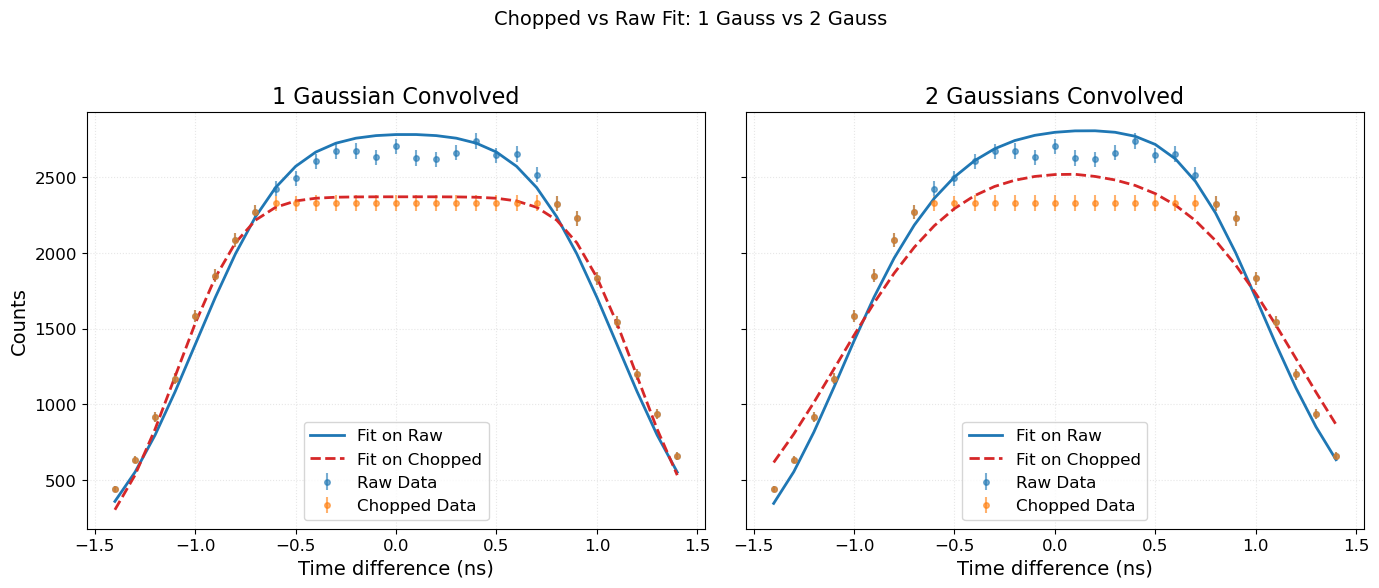


--- Fit Results ---
1 Gaussian:
  Raw     | σ = 0.3544, χ² = 230.91, χ²/ν = 9.24
  Chopped | σ = 0.2659, χ² = 127.51, χ²/ν = 5.10

2 Gaussians:
  Raw     | σ₁ = 0.2906, σ₂ = 0.3337, χ² = 195.54, χ²/ν = 8.89
  Chopped | σ₁ = -0.0011, σ₂ = 0.4555, χ² = 469.85, χ²/ν = 21.36


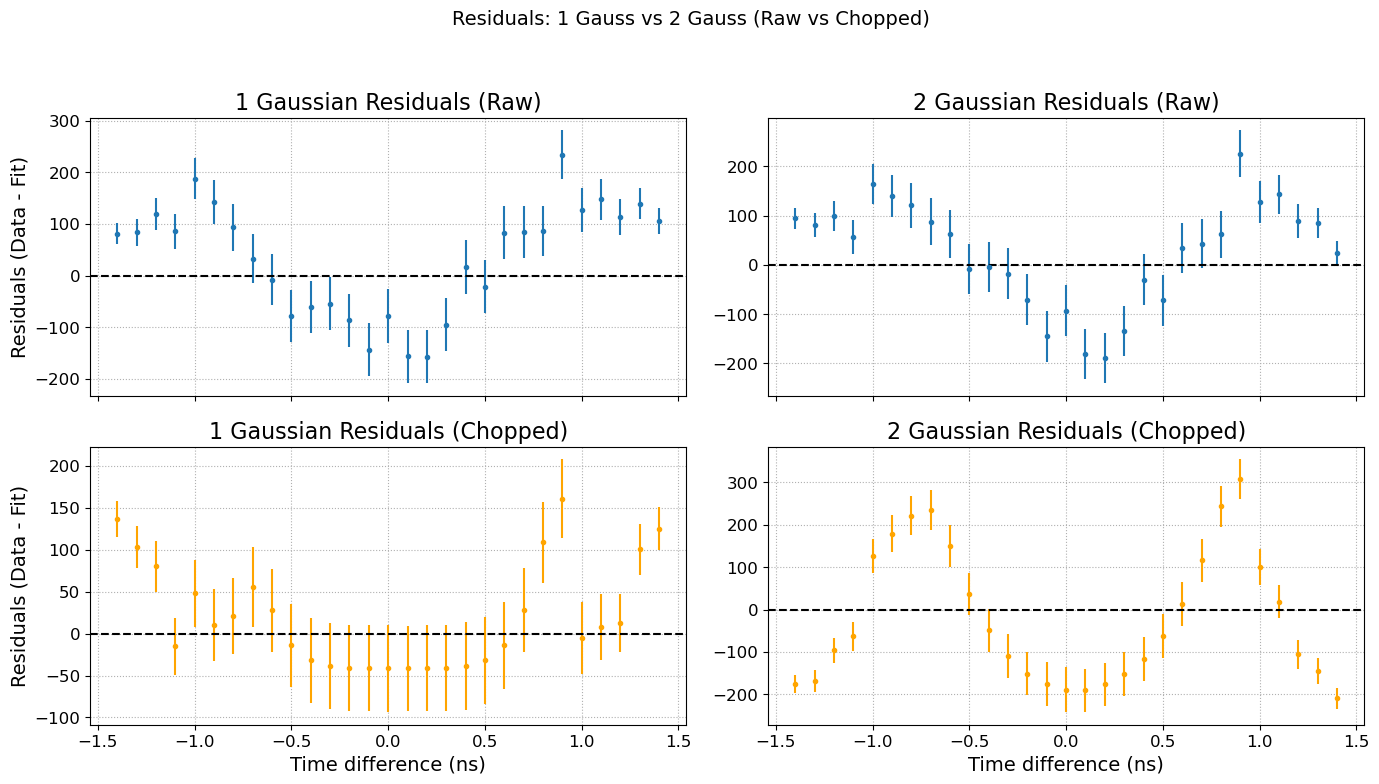

In [16]:
plot_chopped_vs_raw_dual(
    x_root_cut,
    timeDiff_cut,
    countsChopped_cut,
    y_err_cut,
    convolve_fixed_1gauss,
    popt_1gauss,
    popt_1gauss_chopped,
    convolve_fixed_2gauss,
    popt_2gauss,
    popt_2gauss_chopped
)
plot_residuals_dual(
    x_root_cut,
    timeDiff_cut,
    countsChopped_cut,
    y_err_cut,
    convolve_fixed_1gauss,
    popt_1gauss,
    popt_1gauss_chopped,
    convolve_fixed_2gauss,
    popt_2gauss,
    popt_2gauss_chopped
)



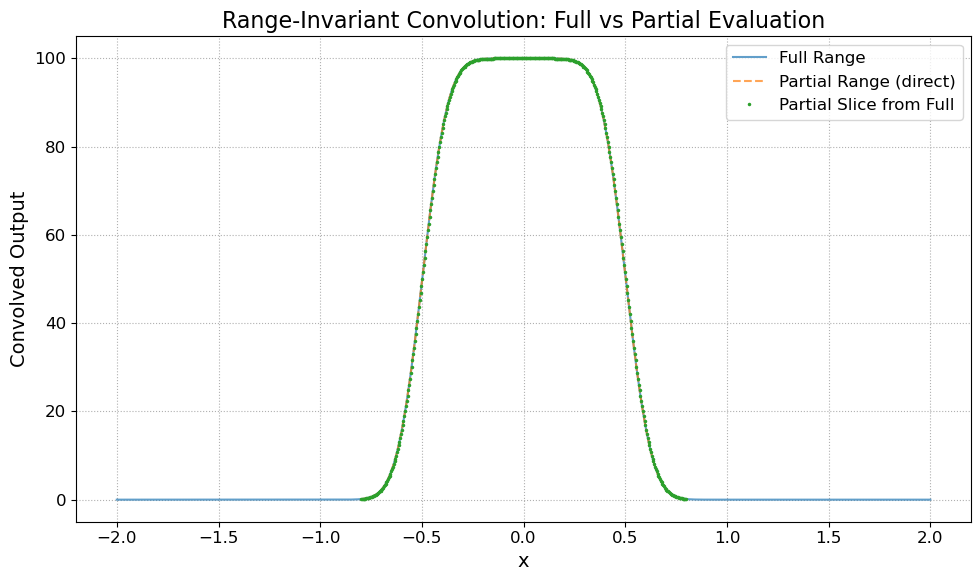

Max absolute difference between partial and full overlap: 1.4211e-13
Mean absolute difference: 6.3839e-14


In [17]:
# --- Parameters for the model ---
amp = 100
width = 1.0
mean = 0.0
sigma = 0.1

# --- x-ranges ---
x_full = np.linspace(-2, 2, 1000)
x_partial = x_full[300:700]  # overlapping subset (approximately [-0.4, 0.4])

# --- Evaluate model ---
y_full = convolve_fixed_1gauss(x_full, amp, width, mean, sigma)
y_partial = convolve_fixed_1gauss(x_partial, amp, width, mean, sigma)

# --- Compare values at shared x-points ---
x_overlap = x_partial
y_overlap_from_full = convolve_fixed_1gauss(x_full, amp, width, mean, sigma)[300:700]

# --- Plot ---
plt.figure(figsize=(10, 6))
plt.plot(x_full, y_full, label='Full Range', alpha=0.7)
plt.plot(x_partial, y_partial, '--', label='Partial Range (direct)', alpha=0.7)
plt.plot(x_overlap, y_overlap_from_full, '.', label='Partial Slice from Full', markersize=3)

plt.xlabel("x")
plt.ylabel("Convolved Output")
plt.title("Range-Invariant Convolution: Full vs Partial Evaluation")
plt.legend()
plt.grid(True, linestyle=':')
plt.tight_layout()
plt.show()

# --- Optional: numeric error ---
diff = np.abs(y_partial - y_overlap_from_full)
print(f"Max absolute difference between partial and full overlap: {np.max(diff):.4e}")
print(f"Mean absolute difference: {np.mean(diff):.4e}")

# Masking

### X value based lowkey guessing

In [18]:
def fit_chopped_1gauss_flanks(x, y, yerr, func, p0, flat_fraction=0.4):
    """
    Fit only the flanks of the chopped data (ignore central flat region).
    flat_fraction: fractional width of the central region to ignore.
    """
    x = np.array(x)
    y = np.array(y)
    yerr = np.array(yerr)

    # Step 1: Calculate central region to exclude
    x_center = np.mean(x)
    x_width = x[-1] - x[0]
    flat_half_width = (flat_fraction / 2) * x_width

    # Mask out central flat region
    mask = (x < x_center - flat_half_width) | (x > x_center + flat_half_width)
    x_flank = x[mask]
    y_flank = y[mask]
    yerr_flank = yerr[mask]

    # Step 2: Fit
    from scipy.optimize import curve_fit
    popt, pcov = curve_fit(func, x_flank, y_flank, sigma=yerr_flank, absolute_sigma=True, p0=p0)

    # Step 3: Fit quality
    y_fit = func(x_flank, *popt)
    residuals = y_flank - y_fit
    chi2 = np.sum((residuals / yerr_flank) ** 2)
    dof = len(x_flank) - len(popt)
    chi2_red = chi2 / dof

    return popt, chi2, chi2_red, x_flank, y_flank, y_fit


In [19]:
for ff in [0.2, 0.3, 0.4, 0.5]:
    popt, chi2, chi2_red, _, _, _ = fit_chopped_1gauss_flanks(
        x_root_cut, countsChopped_cut, y_err_cut,
        convolve_fixed_1gauss, popt_1gauss_chopped,
        flat_fraction=ff
    )
    print(f"flat_fraction={ff:.1f}  σ={popt[3]:.4f},  χ²/ν={chi2_red:.2f}")


flat_fraction=0.2  σ=0.4182,  χ²/ν=2.68
flat_fraction=0.3  σ=0.4920,  χ²/ν=1.94
flat_fraction=0.4  σ=0.5235,  χ²/ν=2.18
flat_fraction=0.5  σ=0.5794,  χ²/ν=8.08


In [20]:
# Initial guess from earlier chopped fit
popt_1gauss_chopped, _ = curve_fit(convolve_fixed_1gauss, x_root_cut, countsChopped_cut, p0=p0_1gauss_chopped)
p0_flank = popt_1gauss_chopped  # or re-compute with get_initial_guess_1gauss(...)

# Run flank-only fit
popt_flank, chi2_flank, chi2red_flank, x_flank, y_flank, y_fit_flank = fit_chopped_1gauss_flanks(
    x_root_cut, countsChopped_cut, y_err_cut,
    convolve_fixed_1gauss, p0_flank, flat_fraction=0.4
)

# Print results
print("\n--- Flank-Only Fit ---")
print(f"σ (timing resolution): {popt_flank[3]:.4f}")
print(f"χ²: {chi2_flank:.2f}, χ²/ν: {chi2red_flank:.2f}")



--- Flank-Only Fit ---
σ (timing resolution): 0.5235
χ²: 30.49, χ²/ν: 2.18


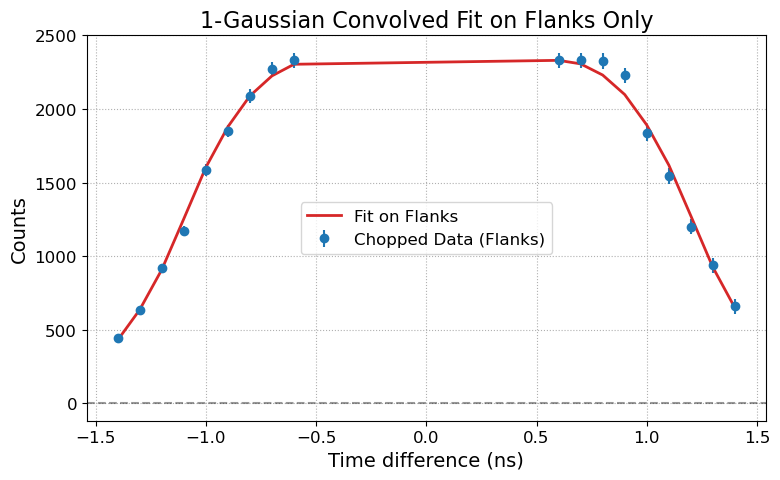

In [21]:
plt.figure(figsize=(8, 5))
plt.errorbar(x_flank, y_flank, yerr=y_err_cut[:len(x_flank)], fmt='o', label="Chopped Data (Flanks)")
plt.plot(x_flank, y_fit_flank, label="Fit on Flanks", color='tab:red', linewidth=2)
plt.axhline(0, color='black', linestyle='--', alpha=0.4)
plt.title("1-Gaussian Convolved Fit on Flanks Only")
plt.xlabel("Time difference (ns)")
plt.ylabel("Counts")
plt.legend()
plt.grid(True, linestyle=':')
plt.tight_layout()
plt.show()

### Slope based

In [22]:
def get_flank_mask_yonly(x, y, threshold_frac=0.95):
    """
    Return a mask for the flanks by removing only the top (flat) region.
    threshold_frac: fractional height of max(y) to define top to exclude
    """
    y = np.array(y)
    y_max = np.max(y)
    return y < (threshold_frac * y_max)
def get_flank_mask_slope_based(x, y, buffer_bins=2, slope_threshold_frac=0.1):
    """
    Create a mask that captures the falling edges (flanks) of the square wave
    using the derivative to find transition zones.
    
    buffer_bins: how many bins to keep around each flank
    slope_threshold_frac: fraction of max slope used to detect edge regions
    """
    x = np.array(x)
    y = np.array(y)

    dy = np.gradient(y, x)
    dy_abs = np.abs(dy)
    slope_max = np.max(dy_abs)
    slope_thresh = slope_threshold_frac * slope_max

    # Find where slope exceeds threshold — this gives flank zones
    flank_indices = np.where(dy_abs > slope_thresh)[0]

    # Initialize mask to all False
    mask = np.zeros_like(y, dtype=bool)

    # Turn on buffer regions around detected slopes
    for idx in flank_indices:
        start = max(0, idx - buffer_bins)
        end = min(len(y), idx + buffer_bins + 1)
        mask[start:end] = True

    return mask


def fit_chopped_1gauss_flanks(x, y, yerr, func, p0, buffer_bins=5, slope_threshold_frac=0.1):
    """
    Fit chopped data to a 1-Gaussian model using slope-based flank masking.
    Returns fitted parameters, chi², reduced chi², flank data, and covariance matrix.
    """
    x = np.array(x)
    y = np.array(y)
    yerr = np.array(yerr)

    # Build mask from slope
    mask = get_flank_mask_slope_based(x, y, buffer_bins=buffer_bins, slope_threshold_frac=slope_threshold_frac)

    x_flank = x[mask]
    y_flank = y[mask]
    yerr_flank = yerr[mask]

    from scipy.optimize import curve_fit
    popt, pcov = curve_fit(func, x_flank, y_flank, sigma=yerr_flank, absolute_sigma=True, p0=p0)

    y_fit = func(x_flank, *popt)
    residuals = y_flank - y_fit
    chi2 = np.sum((residuals / yerr_flank) ** 2)
    dof = len(x_flank) - len(popt)
    chi2_red = chi2 / dof

    return popt, pcov, chi2, chi2_red, x_flank, y_flank, y_fit, mask




def scan_slope_flank_grid(x, y, yerr, func, p0, buffer_vals, slope_vals):
    """
    Grid search for best fit quality using slope-based flank masking.
    
    Parameters:
    - x, y, yerr: input data arrays
    - func: model function (e.g. convolve_fixed_1gauss)
    - p0: initial parameter guess
    - buffer_vals: list of buffer_bins to scan
    - slope_vals: list of slope_threshold_frac values to scan

    Returns:
    - results: list of (buffer, slope_thresh, sigma, chi2_red)
    """
    results = []
    for buffer in buffer_vals:
        for slope in slope_vals:
            try:
                popt, chi2, chi2_red, _, _, _ = fit_chopped_1gauss_flanks(
                    x, y, yerr, func, p0,
                    buffer_bins=buffer,
                    slope_threshold_frac=slope
                )
                sigma = popt[3]
                results.append((buffer, slope, sigma, chi2_red))
            except:
                results.append((buffer, slope, None, None))
    return results


In [23]:
# Initial parameter guess
p0 = get_initial_guess_1gauss(x_root_cut, countsChopped_cut)

# Parameter ranges to test
buffer_vals = [2, 3, 4, 5, 6]
slope_vals = [0.05, 0.075, 0.10, 0.125, 0.15]

# Run grid scan
results = scan_slope_flank_grid(
    x_root_cut,
    countsChopped_cut,
    y_err_cut,
    convolve_fixed_1gauss,
    p0,
    buffer_vals,
    slope_vals
)

# Print clean table
print(" buffer | slope_thresh |   σ (ns)   |  χ²/ν ")
print("---------------------------------------------")
for b, s, sigma, chi2r in results:
    if sigma is None:
        print(f"   {b:4}  |     {s:.3f}     |     ---    |   --- ")
    else:
        print(f"   {b:4}  |     {s:.3f}     |  {sigma:8.4f} |  {chi2r:6.2f}")



 buffer | slope_thresh |   σ (ns)   |  χ²/ν 
---------------------------------------------
      2  |     0.050     |     ---    |   --- 
      2  |     0.075     |     ---    |   --- 
      2  |     0.100     |     ---    |   --- 
      2  |     0.125     |     ---    |   --- 
      2  |     0.150     |     ---    |   --- 
      3  |     0.050     |     ---    |   --- 
      3  |     0.075     |     ---    |   --- 
      3  |     0.100     |     ---    |   --- 
      3  |     0.125     |     ---    |   --- 
      3  |     0.150     |     ---    |   --- 
      4  |     0.050     |     ---    |   --- 
      4  |     0.075     |     ---    |   --- 
      4  |     0.100     |     ---    |   --- 
      4  |     0.125     |     ---    |   --- 
      4  |     0.150     |     ---    |   --- 
      5  |     0.050     |     ---    |   --- 
      5  |     0.075     |     ---    |   --- 
      5  |     0.100     |     ---    |   --- 
      5  |     0.125     |     ---    |   --- 
      5  |     0

In [24]:
# how to open a root file in python

with uproot.open("/Users/sidne/DarkLight 2025/output00049.root") as f:
    fileID = "t14ns_1458" # this is the nicest plot, start here then try t58ns_1458
    timeDiff = f["dltdc"][fileID].to_numpy()[0] #y data
    #t14 = f["dltdc"]["t14ns_1458"].to_numpy()[0]
    #t58 = f["dltdc"]["t58ns_1458"].to_numpy()[0]
    #t23 = f["dltdc"]["t23ns_2367"].to_numpy()[0]
    #t67 = f["dltdc"]["t67ns_2367"].to_numpy()[0]
    x_root = f["dltdc"][fileID].to_numpy()[1][0:-1] #x data
    
    timeDiff_firstHalf = timeDiff[0:int(len(timeDiff)/2)]
    timeDiff_lastHalf = timeDiff[int(len(timeDiff)/2):-1]

    
    #Store index where the data is 10% of the max value for that portion of data
    first10pmaxIndex = 0
    last10pmaxIndex = 0
    threshold = 0.15 #Proportion of the max we want to cut at (choose data greater than this proportion of the max)
    foundMax = 0 #Switch to be changed once we find the point crossing the threshold of the max of that part of the data
    i = 0
    j = 0

    while (foundMax == 0) and (i < len(timeDiff_firstHalf)):
        
        if timeDiff_firstHalf[i] > threshold*max(timeDiff_firstHalf):
            first10pmaxIndex = i
            foundMax = 1            
        i = i+1
        
    while (foundMax != 2) and (j < len(timeDiff_lastHalf)):
        
        if timeDiff_lastHalf[len(timeDiff_lastHalf) - 1 - j] > threshold*max(timeDiff_lastHalf):
            last10pmaxIndex = len(timeDiff_lastHalf) - 1 - j
            foundMax = 2            
        j = j+1
            
    #Cut data
    timeDiff_cut = timeDiff[first10pmaxIndex:len(timeDiff_firstHalf)+last10pmaxIndex]
    x_root_cut = x_root[first10pmaxIndex:len(timeDiff_firstHalf)+last10pmaxIndex]
    
    #Calculate y error bars
    y_err = []
    for i in range(len(timeDiff)):
        y_err.append(np.sqrt(timeDiff[i]))
        
    y_err_cut = []
    for i in range(len(timeDiff_cut)):
        y_err_cut.append(np.sqrt(timeDiff_cut[i]))
        
        
    # NEW FOR CHOPPING OFF THE TOP
    peakHeight = max(timeDiff_cut)
    countsChopped_cut = np.zeros(len(timeDiff_cut))
    countsChopped_cut.tolist()
    
    for i in range(len(timeDiff_cut)):
        if timeDiff_cut[i]>((1-threshold)*peakHeight):
            countsChopped_cut[i] = (1-threshold)*peakHeight
        
        else:
            countsChopped_cut[i] = timeDiff_cut[i]
                  
#plt.plot(x_root_cut,timeDiff_cut)


In [25]:
popt_flank, pcov_flank, chi2_flank, chi2red_flank, x_flank, y_flank, y_fit_flank, flank_mask = fit_chopped_1gauss_flanks(
    x_root_cut, countsChopped_cut, y_err_cut,
    convolve_fixed_1gauss, p0=p0_flank,
    slope_threshold_frac=0.05, buffer_bins=1
)

# Get σ and its uncertainty
sigma_idx = 3  # index of σ
sigma_val = popt_flank[sigma_idx]
sigma_err = np.sqrt(pcov_flank[sigma_idx, sigma_idx])

print(f"σ (timing resolution): {sigma_val:.4f} ± {sigma_err:.4f} ns")

print(f"Number of flank points: {len(x_flank)}")
print("Covariance matrix:")
print(pcov_flank)

# Print results
print("\n--- Slope-Based Flank Fit ---")
print(f"σ (timing resolution): {popt_flank[3]:.4f}")
print(f"χ²: {chi2_flank:.2f}, χ²/ν: {chi2red_flank:.2f}")


σ (timing resolution): 0.5389 ± inf ns
Number of flank points: 18
Covariance matrix:
[[inf inf inf inf]
 [inf inf inf inf]
 [inf inf inf inf]
 [inf inf inf inf]]

--- Slope-Based Flank Fit ---
σ (timing resolution): 0.5389
χ²: 36.78, χ²/ν: 2.63


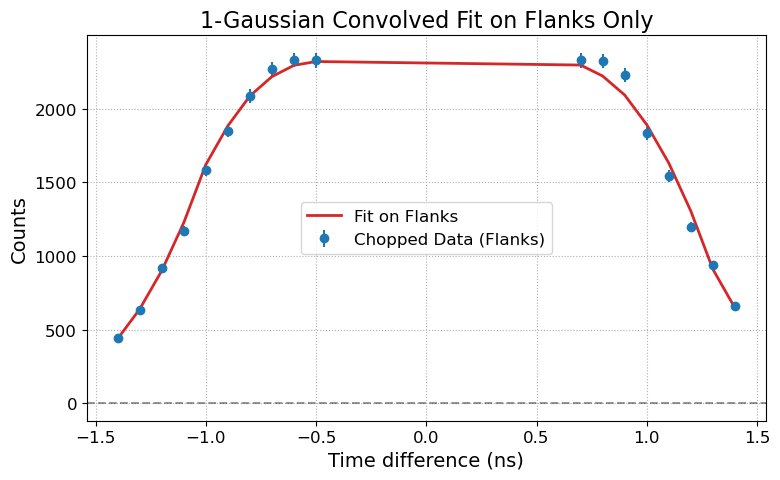

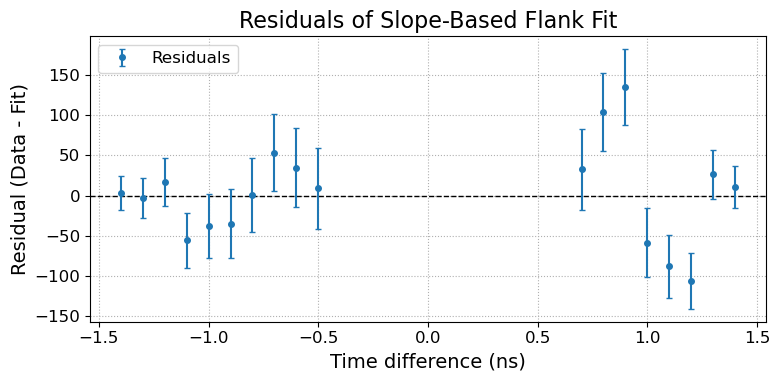

In [26]:

flank_mask = np.asarray(flank_mask)  # Ensure it's a NumPy array
y_err_cut = np.asarray(y_err_cut)    # Just in case

yerr_flank = y_err_cut[flank_mask]

plt.figure(figsize=(8, 5))
plt.errorbar(x_flank, y_flank, yerr=yerr_flank, fmt='o', label="Chopped Data (Flanks)")
plt.plot(x_flank, y_fit_flank, label="Fit on Flanks", color='tab:red', linewidth=2)
plt.axhline(0, color='black', linestyle='--', alpha=0.4)
plt.title("1-Gaussian Convolved Fit on Flanks Only")
plt.xlabel("Time difference (ns)")
plt.ylabel("Counts")
plt.legend()
plt.grid(True, linestyle=':')
plt.tight_layout()
plt.show()

residuals = y_flank - y_fit_flank

plt.figure(figsize=(8, 4))
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.errorbar(x_flank, residuals, yerr=yerr_flank, fmt='o', markersize=4, capsize=2, label='Residuals')
plt.title("Residuals of Slope-Based Flank Fit")
plt.xlabel("Time difference (ns)")
plt.ylabel("Residual (Data - Fit)")
plt.grid(True, linestyle=':')
plt.legend()
plt.tight_layout()
plt.show()



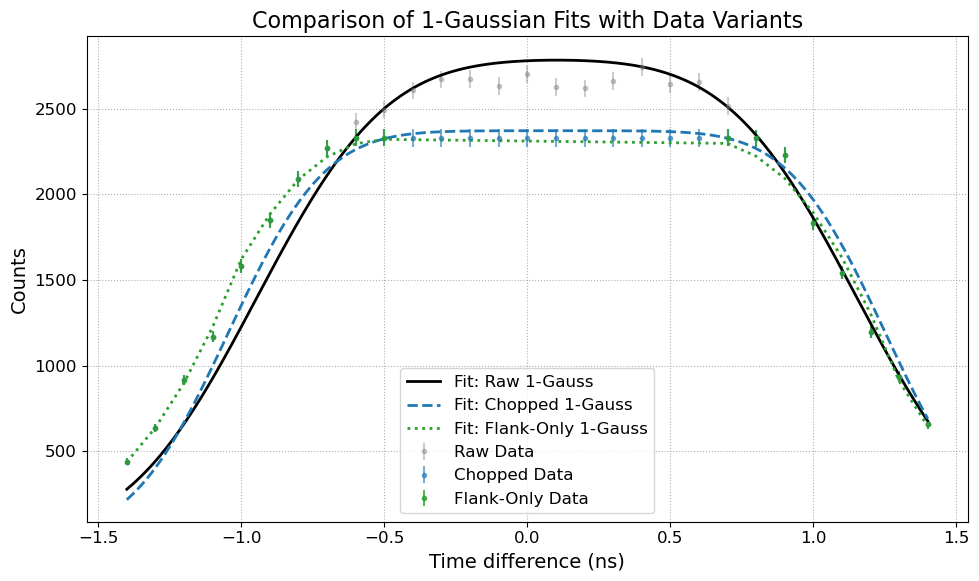


--- Fit Report: Raw ---
  σ (timing resolution): 0.3544
  χ²: 230.91
  χ² / ν (reduced): 9.24

--- Fit Report: Chopped ---
  σ (timing resolution): 0.2659
  χ²: 127.51
  χ² / ν (reduced): 5.10

--- Fit Report: Flank Only ---
  σ (timing resolution): 0.5389
  χ²: 36.84
  χ² / ν (reduced): 2.63


<Figure size 640x480 with 0 Axes>

In [27]:
# Recompute flank mask for data visualization
flank_mask = get_flank_mask_slope_based(x_root_cut, countsChopped_cut, buffer_bins=1, slope_threshold_frac=0.025)
x_flank_vis = x_root_cut[flank_mask]
y_flank_vis = countsChopped_cut[flank_mask]
y_err_cut = np.array(y_err_cut)  # Ensure it's an array
yerr_flank_vis = y_err_cut[flank_mask]

# Dense x-range for smooth fits
x_dense = np.linspace(x_root_cut[0], x_root_cut[-1], 500)
y_fit_raw = convolve_fixed_1gauss(x_dense, *popt_1gauss)
y_fit_chopped = convolve_fixed_1gauss(x_dense, *popt_1gauss_chopped)


# Plot
plt.figure(figsize=(10, 6))

# Plot all three data versions
plt.errorbar(x_root_cut, timeDiff_cut, yerr=y_err_cut, fmt='o', markersize=3, label="Raw Data", alpha=0.4, color='gray')
plt.errorbar(x_root_cut, countsChopped_cut, yerr=y_err_cut, fmt='o', markersize=3, label="Chopped Data", alpha=0.6, color='tab:blue')
plt.errorbar(x_flank_vis, y_flank_vis, yerr=yerr_flank_vis, fmt='o', markersize=3, label="Flank-Only Data", alpha=0.8, color='tab:green')

# Overlay fits
plt.plot(x_dense, y_fit_raw, label="Fit: Raw 1-Gauss", linewidth=2, color='black')
plt.plot(x_dense, y_fit_chopped, label="Fit: Chopped 1-Gauss", linewidth=2, linestyle='--', color='tab:blue')
plt.plot(x_flank, y_fit_flank, label="Fit: Flank-Only 1-Gauss", linewidth=2, linestyle=':', color='tab:green')

plt.title("Comparison of 1-Gaussian Fits with Data Variants")
plt.xlabel("Time difference (ns)")
plt.ylabel("Counts")
plt.legend()
plt.grid(True, linestyle=':')
plt.tight_layout()
plt.show()
# Compute fit quality for each method
chi2_raw, chi2red_raw = report_fit_quality(x_root_cut, timeDiff_cut, y_err_cut, convolve_fixed_1gauss, popt_1gauss, label="Raw")
chi2_chop, chi2red_chop = report_fit_quality(x_root_cut, countsChopped_cut, y_err_cut, convolve_fixed_1gauss, popt_1gauss_chopped, label="Chopped")
chi2_flank, chi2red_flank = report_fit_quality(x_flank, y_flank, np.sqrt(np.clip(y_flank, 1, None)), convolve_fixed_1gauss, popt_flank, label="Flank Only")

fit_summary = (
    f"Raw Fit:       σ = {popt_1gauss[3]:.4f} ns   χ²/ν = {chi2red_raw:.2f}\n"
    f"Chopped Fit:   σ = {popt_1gauss_chopped[3]:.4f} ns   χ²/ν = {chi2red_chop:.2f}\n"
    f"Flank Fit:     σ = {popt_flank[3]:.4f} ns   χ²/ν = {chi2red_flank:.2f}"
)
plt.gcf().text(0.1, -0.15, fit_summary, fontsize=10, family='monospace', va='top')
plt.tight_layout(rect=[0, 0.05, 1, 1])  # leaves space at bottom


### Second file 

In [28]:
# how to open a root file in python

with uproot.open("/Users/sidne/DarkLight 2025/output00049.root") as f:
    fileID = "t58ns_1458" # this is the nicest plot, start here then try t58ns_1458
    timeDiff = f["dltdc"][fileID].to_numpy()[0] #y data
    #t14 = f["dltdc"]["t14ns_1458"].to_numpy()[0]
    #t58 = f["dltdc"]["t58ns_1458"].to_numpy()[0]
    #t23 = f["dltdc"]["t23ns_2367"].to_numpy()[0]
    #t67 = f["dltdc"]["t67ns_2367"].to_numpy()[0]
    x_root = f["dltdc"][fileID].to_numpy()[1][0:-1] #x data
    
    timeDiff_firstHalf = timeDiff[0:int(len(timeDiff)/2)]
    timeDiff_lastHalf = timeDiff[int(len(timeDiff)/2):-1]

    
    #Store index where the data is 10% of the max value for that portion of data
    first10pmaxIndex = 0
    last10pmaxIndex = 0
    threshold = 0.15 #Proportion of the max we want to cut at (choose data greater than this proportion of the max)
    foundMax = 0 #Switch to be changed once we find the point crossing the threshold of the max of that part of the data
    i = 0
    j = 0

    while (foundMax == 0) and (i < len(timeDiff_firstHalf)):
        
        if timeDiff_firstHalf[i] > threshold*max(timeDiff_firstHalf):
            first10pmaxIndex = i
            foundMax = 1            
        i = i+1
        
    while (foundMax != 2) and (j < len(timeDiff_lastHalf)):
        
        if timeDiff_lastHalf[len(timeDiff_lastHalf) - 1 - j] > threshold*max(timeDiff_lastHalf):
            last10pmaxIndex = len(timeDiff_lastHalf) - 1 - j
            foundMax = 2            
        j = j+1
            
    #Cut data
    timeDiff_cut = timeDiff[first10pmaxIndex:len(timeDiff_firstHalf)+last10pmaxIndex]
    x_root_cut = x_root[first10pmaxIndex:len(timeDiff_firstHalf)+last10pmaxIndex]
    
    #Calculate y error bars
    y_err = []
    for i in range(len(timeDiff)):
        y_err.append(np.sqrt(timeDiff[i]))
        
    y_err_cut = []
    for i in range(len(timeDiff_cut)):
        y_err_cut.append(np.sqrt(timeDiff_cut[i]))
        
        
    # NEW FOR CHOPPING OFF THE TOP
    peakHeight = max(timeDiff_cut)
    countsChopped_cut = np.zeros(len(timeDiff_cut))
    countsChopped_cut.tolist()
    
    for i in range(len(timeDiff_cut)):
        if timeDiff_cut[i]>((1-threshold)*peakHeight):
            countsChopped_cut[i] = (1-threshold)*peakHeight
        
        else:
            countsChopped_cut[i] = timeDiff_cut[i]
                  
#plt.plot(x_root_cut,timeDiff_cut)



--- Slope-Based Flank Fit ---
σ (timing resolution): 0.4049
χ²: 495.08, χ²/ν: 33.01


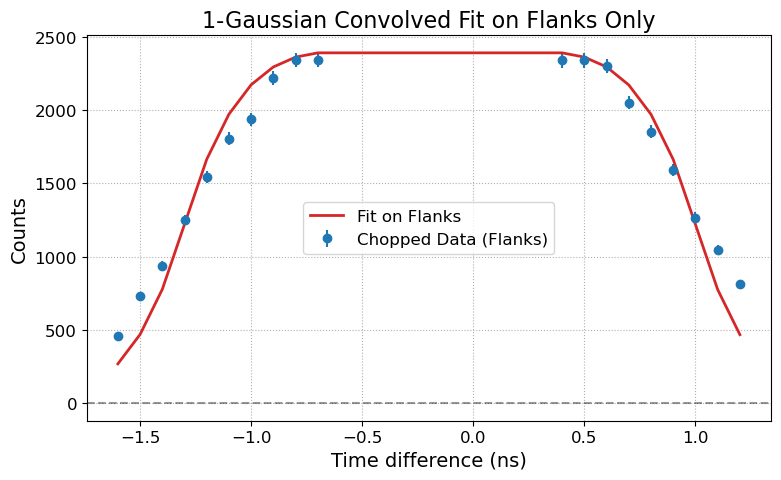

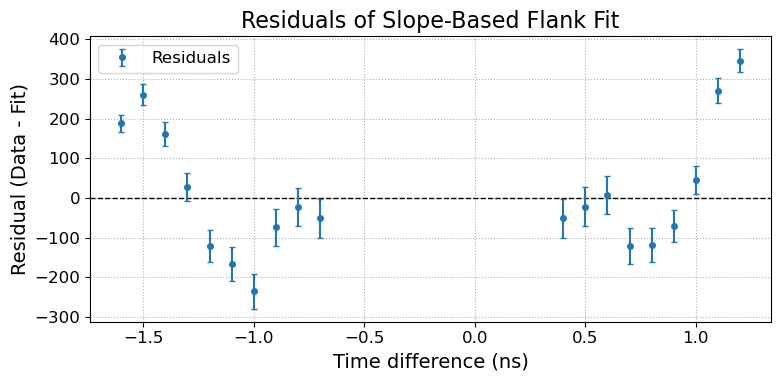

In [29]:
# Initial guess from earlier chopped fit
popt_1gauss_chopped, _ = curve_fit(convolve_fixed_1gauss, x_root_cut, countsChopped_cut, p0=p0_1gauss_chopped)
p0_flank = popt_1gauss_chopped  # or use get_initial_guess_1gauss(x_root_cut, countsChopped_cut)

popt_flank, pcov_flank, chi2_flank, chi2red_flank, x_flank, y_flank, y_fit_flank, flank_mask = fit_chopped_1gauss_flanks(
    x_root_cut, countsChopped_cut, y_err_cut,
    convolve_fixed_1gauss, p0=p0_flank,
    slope_threshold_frac=0.05, buffer_bins=1
)


# Print results
print("\n--- Slope-Based Flank Fit ---")
print(f"σ (timing resolution): {popt_flank[3]:.4f}")
print(f"χ²: {chi2_flank:.2f}, χ²/ν: {chi2red_flank:.2f}")

flank_mask = np.asarray(flank_mask)  # Ensure it's a NumPy array
y_err_cut = np.asarray(y_err_cut)    # Just in case

yerr_flank = y_err_cut[flank_mask]

plt.figure(figsize=(8, 5))
plt.errorbar(x_flank, y_flank, yerr=yerr_flank, fmt='o', label="Chopped Data (Flanks)")
plt.plot(x_flank, y_fit_flank, label="Fit on Flanks", color='tab:red', linewidth=2)
plt.axhline(0, color='black', linestyle='--', alpha=0.4)
plt.title("1-Gaussian Convolved Fit on Flanks Only")
plt.xlabel("Time difference (ns)")
plt.ylabel("Counts")
plt.legend()
plt.grid(True, linestyle=':')
plt.tight_layout()
plt.show()

residuals = y_flank - y_fit_flank

plt.figure(figsize=(8, 4))
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.errorbar(x_flank, residuals, yerr=yerr_flank, fmt='o', markersize=4, capsize=2, label='Residuals')
plt.title("Residuals of Slope-Based Flank Fit")
plt.xlabel("Time difference (ns)")
plt.ylabel("Residual (Data - Fit)")
plt.grid(True, linestyle=':')
plt.legend()
plt.tight_layout()
plt.show()



### Third file 

In [30]:
# how to open a root file in python

with uproot.open("/Users/sidne/DarkLight 2025/output00049.root") as f:
    fileID = "t23ns_2367" # this is the nicest plot, start here then try t58ns_1458
    timeDiff = f["dltdc"][fileID].to_numpy()[0] #y data
    #t14 = f["dltdc"]["t14ns_1458"].to_numpy()[0]
    #t58 = f["dltdc"]["t58ns_1458"].to_numpy()[0]
    #t23 = f["dltdc"]["t23ns_2367"].to_numpy()[0]
    #t67 = f["dltdc"]["t67ns_2367"].to_numpy()[0]
    x_root = f["dltdc"][fileID].to_numpy()[1][0:-1] #x data
    
    timeDiff_firstHalf = timeDiff[0:int(len(timeDiff)/2)]
    timeDiff_lastHalf = timeDiff[int(len(timeDiff)/2):-1]

    
    #Store index where the data is 10% of the max value for that portion of data
    first10pmaxIndex = 0
    last10pmaxIndex = 0
    threshold = 0.15 #Proportion of the max we want to cut at (choose data greater than this proportion of the max)
    foundMax = 0 #Switch to be changed once we find the point crossing the threshold of the max of that part of the data
    i = 0
    j = 0

    while (foundMax == 0) and (i < len(timeDiff_firstHalf)):
        
        if timeDiff_firstHalf[i] > threshold*max(timeDiff_firstHalf):
            first10pmaxIndex = i
            foundMax = 1            
        i = i+1
        
    while (foundMax != 2) and (j < len(timeDiff_lastHalf)):
        
        if timeDiff_lastHalf[len(timeDiff_lastHalf) - 1 - j] > threshold*max(timeDiff_lastHalf):
            last10pmaxIndex = len(timeDiff_lastHalf) - 1 - j
            foundMax = 2            
        j = j+1
            
    #Cut data
    timeDiff_cut = timeDiff[first10pmaxIndex:len(timeDiff_firstHalf)+last10pmaxIndex]
    x_root_cut = x_root[first10pmaxIndex:len(timeDiff_firstHalf)+last10pmaxIndex]
    
    #Calculate y error bars
    y_err = []
    for i in range(len(timeDiff)):
        y_err.append(np.sqrt(timeDiff[i]))
        
    y_err_cut = []
    for i in range(len(timeDiff_cut)):
        y_err_cut.append(np.sqrt(timeDiff_cut[i]))
        
        
    # NEW FOR CHOPPING OFF THE TOP
    peakHeight = max(timeDiff_cut)
    countsChopped_cut = np.zeros(len(timeDiff_cut))
    countsChopped_cut.tolist()
    
    for i in range(len(timeDiff_cut)):
        if timeDiff_cut[i]>((1-threshold)*peakHeight):
            countsChopped_cut[i] = (1-threshold)*peakHeight
        
        else:
            countsChopped_cut[i] = timeDiff_cut[i]
                  
#plt.plot(x_root_cut,timeDiff_cut)



--- Slope-Based Flank Fit ---
σ (timing resolution): 0.6517
χ²: 42.70, χ²/ν: 3.05


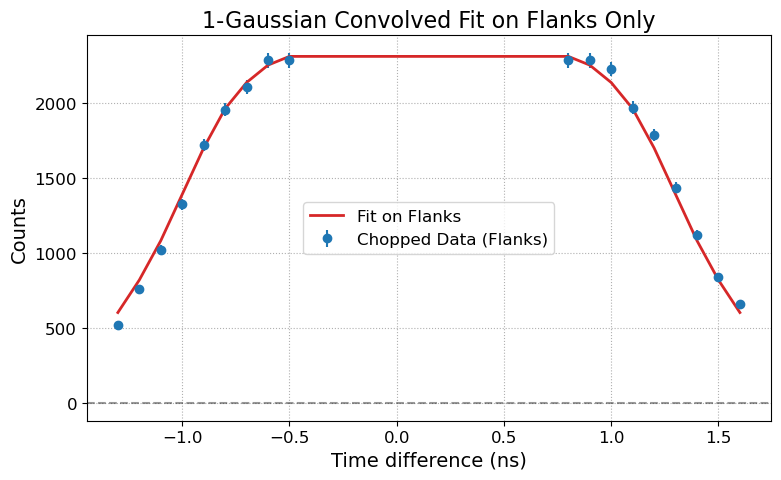

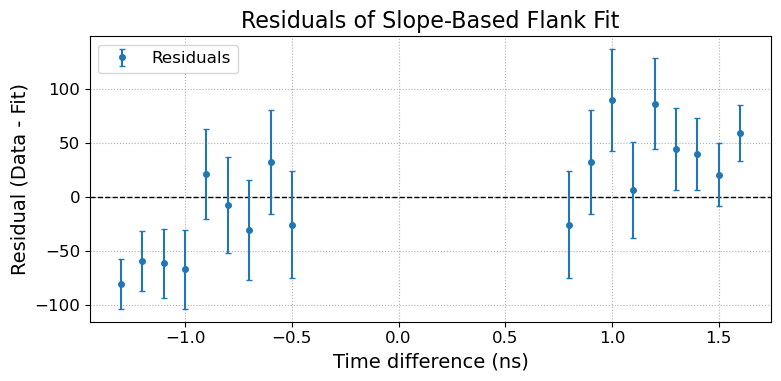

In [31]:
# Initial guess from earlier chopped fit
popt_1gauss_chopped, _ = curve_fit(convolve_fixed_1gauss, x_root_cut, countsChopped_cut, p0=p0_1gauss_chopped)
p0_flank = popt_1gauss_chopped  # or use get_initial_guess_1gauss(x_root_cut, countsChopped_cut)

popt_flank, pcov_flank, chi2_flank, chi2red_flank, x_flank, y_flank, y_fit_flank, flank_mask = fit_chopped_1gauss_flanks(
    x_root_cut, countsChopped_cut, y_err_cut,
    convolve_fixed_1gauss, p0=p0_flank,
    slope_threshold_frac=0.05, buffer_bins=1
)


# Print results
print("\n--- Slope-Based Flank Fit ---")
print(f"σ (timing resolution): {popt_flank[3]:.4f}")
print(f"χ²: {chi2_flank:.2f}, χ²/ν: {chi2red_flank:.2f}")

flank_mask = np.asarray(flank_mask)  # Ensure it's a NumPy array
y_err_cut = np.asarray(y_err_cut)    # Just in case

yerr_flank = y_err_cut[flank_mask]

plt.figure(figsize=(8, 5))
plt.errorbar(x_flank, y_flank, yerr=yerr_flank, fmt='o', label="Chopped Data (Flanks)")
plt.plot(x_flank, y_fit_flank, label="Fit on Flanks", color='tab:red', linewidth=2)
plt.axhline(0, color='black', linestyle='--', alpha=0.4)
plt.title("1-Gaussian Convolved Fit on Flanks Only")
plt.xlabel("Time difference (ns)")
plt.ylabel("Counts")
plt.legend()
plt.grid(True, linestyle=':')
plt.tight_layout()
plt.show()

residuals = y_flank - y_fit_flank

plt.figure(figsize=(8, 4))
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.errorbar(x_flank, residuals, yerr=yerr_flank, fmt='o', markersize=4, capsize=2, label='Residuals')
plt.title("Residuals of Slope-Based Flank Fit")
plt.xlabel("Time difference (ns)")
plt.ylabel("Residual (Data - Fit)")
plt.grid(True, linestyle=':')
plt.legend()
plt.tight_layout()
plt.show()




In [32]:
# how to open a root file in python

with uproot.open("/Users/sidne/DarkLight 2025/output00049.root") as f:
    fileID = "t67ns_2367" # this is the nicest plot, start here then try t58ns_1458
    timeDiff = f["dltdc"][fileID].to_numpy()[0] #y data
    #t14 = f["dltdc"]["t14ns_1458"].to_numpy()[0]
    #t58 = f["dltdc"]["t58ns_1458"].to_numpy()[0]
    #t23 = f["dltdc"]["t23ns_2367"].to_numpy()[0]
    #t67 = f["dltdc"]["t67ns_2367"].to_numpy()[0]
    x_root = f["dltdc"][fileID].to_numpy()[1][0:-1] #x data
    
    timeDiff_firstHalf = timeDiff[0:int(len(timeDiff)/2)]
    timeDiff_lastHalf = timeDiff[int(len(timeDiff)/2):-1]

    
    #Store index where the data is 10% of the max value for that portion of data
    first10pmaxIndex = 0
    last10pmaxIndex = 0
    threshold = 0.15 #Proportion of the max we want to cut at (choose data greater than this proportion of the max)
    foundMax = 0 #Switch to be changed once we find the point crossing the threshold of the max of that part of the data
    i = 0
    j = 0

    while (foundMax == 0) and (i < len(timeDiff_firstHalf)):
        
        if timeDiff_firstHalf[i] > threshold*max(timeDiff_firstHalf):
            first10pmaxIndex = i
            foundMax = 1            
        i = i+1
        
    while (foundMax != 2) and (j < len(timeDiff_lastHalf)):
        
        if timeDiff_lastHalf[len(timeDiff_lastHalf) - 1 - j] > threshold*max(timeDiff_lastHalf):
            last10pmaxIndex = len(timeDiff_lastHalf) - 1 - j
            foundMax = 2            
        j = j+1
            
    #Cut data
    timeDiff_cut = timeDiff[first10pmaxIndex:len(timeDiff_firstHalf)+last10pmaxIndex]
    x_root_cut = x_root[first10pmaxIndex:len(timeDiff_firstHalf)+last10pmaxIndex]
    
    #Calculate y error bars
    y_err = []
    for i in range(len(timeDiff)):
        y_err.append(np.sqrt(timeDiff[i]))
        
    y_err_cut = []
    for i in range(len(timeDiff_cut)):
        y_err_cut.append(np.sqrt(timeDiff_cut[i]))
        
        
    # NEW FOR CHOPPING OFF THE TOP
    peakHeight = max(timeDiff_cut)
    countsChopped_cut = np.zeros(len(timeDiff_cut))
    countsChopped_cut.tolist()
    
    for i in range(len(timeDiff_cut)):
        if timeDiff_cut[i]>((1-threshold)*peakHeight):
            countsChopped_cut[i] = (1-threshold)*peakHeight
        
        else:
            countsChopped_cut[i] = timeDiff_cut[i]
                  
#plt.plot(x_root_cut,timeDiff_cut)



--- Slope-Based Flank Fit ---
σ (timing resolution): 0.5555
χ²: 514.61, χ²/ν: 36.76


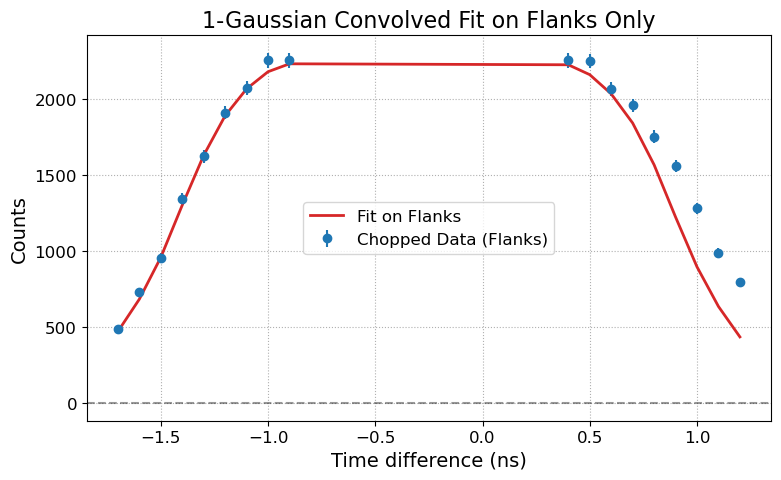

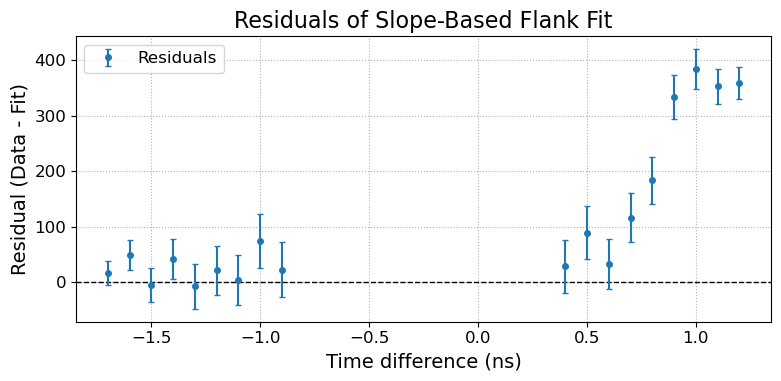

In [33]:
# Initial guess from earlier chopped fit
popt_1gauss_chopped, _ = curve_fit(convolve_fixed_1gauss, x_root_cut, countsChopped_cut, p0=p0_1gauss_chopped)
p0_flank = popt_1gauss_chopped  # or use get_initial_guess_1gauss(x_root_cut, countsChopped_cut)

popt_flank, pcov_flank, chi2_flank, chi2red_flank, x_flank, y_flank, y_fit_flank, flank_mask = fit_chopped_1gauss_flanks(
    x_root_cut, countsChopped_cut, y_err_cut,
    convolve_fixed_1gauss, p0=p0_flank,
    slope_threshold_frac=0.05, buffer_bins=1
)

# Print results
print("\n--- Slope-Based Flank Fit ---")
print(f"σ (timing resolution): {popt_flank[3]:.4f}")
print(f"χ²: {chi2_flank:.2f}, χ²/ν: {chi2red_flank:.2f}")

flank_mask = np.asarray(flank_mask)  # Ensure it's a NumPy array
y_err_cut = np.asarray(y_err_cut)    # Just in case

yerr_flank = y_err_cut[flank_mask]

plt.figure(figsize=(8, 5))
plt.errorbar(x_flank, y_flank, yerr=yerr_flank, fmt='o', label="Chopped Data (Flanks)")
plt.plot(x_flank, y_fit_flank, label="Fit on Flanks", color='tab:red', linewidth=2)
plt.axhline(0, color='black', linestyle='--', alpha=0.4)
plt.title("1-Gaussian Convolved Fit on Flanks Only")
plt.xlabel("Time difference (ns)")
plt.ylabel("Counts")
plt.legend()
plt.grid(True, linestyle=':')
plt.tight_layout()
plt.show()

residuals = y_flank - y_fit_flank

plt.figure(figsize=(8, 4))
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.errorbar(x_flank, residuals, yerr=yerr_flank, fmt='o', markersize=4, capsize=2, label='Residuals')
plt.title("Residuals of Slope-Based Flank Fit")
plt.xlabel("Time difference (ns)")
plt.ylabel("Residual (Data - Fit)")
plt.grid(True, linestyle=':')
plt.legend()
plt.tight_layout()
plt.show()



### Lets try something new

In [34]:
# how to open a root file in python

with uproot.open("/Users/sidne/DarkLight 2025/output00049.root") as f:
    fileID = "t14ns_1458" # this is the nicest plot, start here then try t58ns_1458
    timeDiff = f["dltdc"][fileID].to_numpy()[0] #y data
    #t14 = f["dltdc"]["t14ns_1458"].to_numpy()[0]
    #t58 = f["dltdc"]["t58ns_1458"].to_numpy()[0]
    #t23 = f["dltdc"]["t23ns_2367"].to_numpy()[0]
    #t67 = f["dltdc"]["t67ns_2367"].to_numpy()[0]
    x_root = f["dltdc"][fileID].to_numpy()[1][0:-1] #x data
    
    timeDiff_firstHalf = timeDiff[0:int(len(timeDiff)/2)]
    timeDiff_lastHalf = timeDiff[int(len(timeDiff)/2):-1]

    
    #Store index where the data is 10% of the max value for that portion of data
    first10pmaxIndex = 0
    last10pmaxIndex = 0
    threshold = 0.15 #Proportion of the max we want to cut at (choose data greater than this proportion of the max)
    foundMax = 0 #Switch to be changed once we find the point crossing the threshold of the max of that part of the data
    i = 0
    j = 0

    while (foundMax == 0) and (i < len(timeDiff_firstHalf)):
        
        if timeDiff_firstHalf[i] > threshold*max(timeDiff_firstHalf):
            first10pmaxIndex = i
            foundMax = 1            
        i = i+1
        
    while (foundMax != 2) and (j < len(timeDiff_lastHalf)):
        
        if timeDiff_lastHalf[len(timeDiff_lastHalf) - 1 - j] > threshold*max(timeDiff_lastHalf):
            last10pmaxIndex = len(timeDiff_lastHalf) - 1 - j
            foundMax = 2            
        j = j+1
            
    #Cut data
    timeDiff_cut = timeDiff[first10pmaxIndex:len(timeDiff_firstHalf)+last10pmaxIndex]
    x_root_cut = x_root[first10pmaxIndex:len(timeDiff_firstHalf)+last10pmaxIndex]
    
    #Calculate y error bars
    y_err = []
    for i in range(len(timeDiff)):
        y_err.append(np.sqrt(timeDiff[i]))
        
    y_err_cut = []
    for i in range(len(timeDiff_cut)):
        y_err_cut.append(np.sqrt(timeDiff_cut[i]))
        
        
    # NEW FOR CHOPPING OFF THE TOP
    peakHeight = max(timeDiff_cut)
    countsChopped_cut = np.zeros(len(timeDiff_cut))
    countsChopped_cut.tolist()
    
    for i in range(len(timeDiff_cut)):
        if timeDiff_cut[i]>((1-threshold)*peakHeight):
            countsChopped_cut[i] = (1-threshold)*peakHeight
        
        else:
            countsChopped_cut[i] = timeDiff_cut[i]
                  
#plt.plot(x_root_cut,timeDiff_cut)


In [35]:
def get_flank_mask_yonly(x, y, threshold_frac=0.95):
    """
    Return a mask for the flanks by removing only the top (flat) region.
    threshold_frac: fractional height of max(y) to define top to exclude
    """
    y = np.array(y)
    y_max = np.max(y)
    return y < (threshold_frac * y_max)
def get_flank_mask_slope_based(x, y, buffer_bins=2, slope_threshold_frac=0.1):
    """
    Create a mask that captures the falling edges (flanks) of the square wave
    using the derivative to find transition zones.
    
    buffer_bins: how many bins to keep around each flank
    slope_threshold_frac: fraction of max slope used to detect edge regions
    """
    x = np.array(x)
    y = np.array(y)

    dy = np.gradient(y, x)
    dy_abs = np.abs(dy)
    slope_max = np.max(dy_abs)
    slope_thresh = slope_threshold_frac * slope_max

    # Find where slope exceeds threshold — this gives flank zones
    flank_indices = np.where(dy_abs > slope_thresh)[0]

    # Initialize mask to all False
    mask = np.zeros_like(y, dtype=bool)

    # Turn on buffer regions around detected slopes
    for idx in flank_indices:
        start = max(0, idx - buffer_bins)
        end = min(len(y), idx + buffer_bins + 1)
        mask[start:end] = True

    return mask
def gaussian(x, amp, mean, sigma):
    return amp * np.exp(-0.5 * ((x - mean) / sigma) ** 2)


def fit_gaussian_flanks(x, y, yerr, p0, buffer_bins=5, slope_threshold_frac=0.05):
    """
    Fit only the flanks of the data with a plain Gaussian (no convolution).
    """
    x = np.array(x)
    y = np.array(y)
    yerr = np.array(yerr)

    mask = get_flank_mask_slope_based(x, y, buffer_bins=buffer_bins, slope_threshold_frac=slope_threshold_frac)
    x_flank = x[mask]
    y_flank = y[mask]
    yerr_flank = yerr[mask]

    from scipy.optimize import curve_fit
    popt, pcov = curve_fit(gaussian, x_flank, y_flank, sigma=yerr_flank, absolute_sigma=True, p0=p0)

    y_fit = gaussian(x_flank, *popt)
    residuals = y_flank - y_fit
    chi2 = np.sum((residuals / yerr_flank) ** 2)
    dof = len(x_flank) - len(popt)
    chi2_red = chi2 / dof

    return popt, pcov, chi2, chi2_red, x_flank, y_flank, y_fit

def get_initial_guess_gaussian(x, y):
    amp = np.max(y)
    mean = x[np.argmax(y)]
    half_max = amp / 2

    # Find width at half max
    indices = np.where(y > half_max)[0]
    if len(indices) >= 2:
        fwhm = x[indices[-1]] - x[indices[0]]
    else:
        fwhm = (x[-1] - x[0]) / 2.0
    sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))  # FWHM to sigma

    return [amp, mean, sigma]


def scan_slope_flank_grid(x, y, yerr, func, p0, buffer_vals, slope_vals):
    """
    Grid search for best fit quality using slope-based flank masking.
    
    Parameters:
    - x, y, yerr: input data arrays
    - func: model function (e.g. convolve_fixed_1gauss)
    - p0: initial parameter guess
    - buffer_vals: list of buffer_bins to scan
    - slope_vals: list of slope_threshold_frac values to scan

    Returns:
    - results: list of (buffer, slope_thresh, sigma, chi2_red)
    """
    results = []
    for buffer in buffer_vals:
        for slope in slope_vals:
            try:
                popt, chi2, chi2_red, _, _, _ = fit_chopped_1gauss_flanks(
                    x, y, yerr, func, p0,
                    buffer_bins=buffer,
                    slope_threshold_frac=slope
                )
                sigma = popt[3]
                results.append((buffer, slope, sigma, chi2_red))
            except:
                results.append((buffer, slope, None, None))
    return results

σ (Gaussian-only): 0.7257 ns ± 0.0055 ns
χ² / ν = 11.61

--- Flank Fit Debug Info ---
Flank points used: 16
Covariance matrix:
[[ 3.74393390e+03 -1.01410757e-03 -3.02626752e-01]
 [-1.01410757e-03  1.23863584e-05  9.71325234e-07]
 [-3.02626752e-01  9.71325234e-07  3.00475421e-05]]


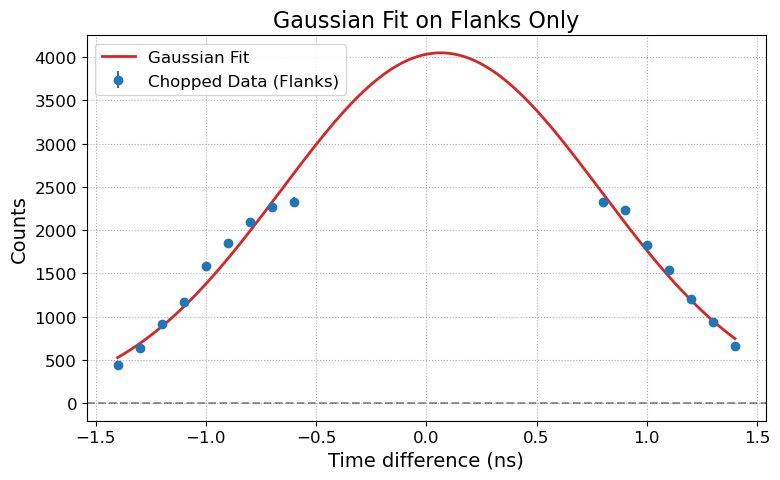

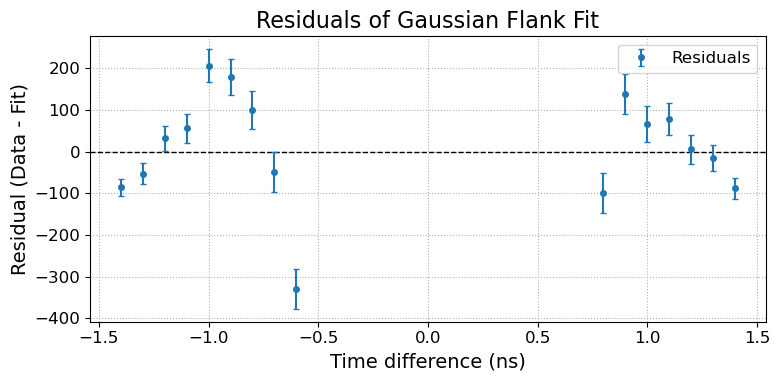

In [36]:
flank_mask = get_flank_mask_slope_based(x_root_cut, countsChopped_cut, buffer_bins=1, slope_threshold_frac=0.05)
x_flank_g = x_root_cut[flank_mask]
y_flank_g = countsChopped_cut[flank_mask]
p0_gauss = get_initial_guess_gaussian(x_flank_g, y_flank_g)


popt_gauss, pcov_gauss, chi2_gauss, chi2red_gauss, x_flank_g, y_flank_g, y_fit_g = fit_gaussian_flanks(
    x_root_cut, countsChopped_cut, y_err_cut,
    p0_gauss, buffer_bins=1, slope_threshold_frac=0.15
)
print(f"σ (Gaussian-only): {popt_gauss[2]:.4f} ns ± {np.sqrt(pcov_gauss[2,2]):.4f} ns")
print(f"χ² / ν = {chi2red_gauss:.2f}")
# Print debugging info
print(f"\n--- Flank Fit Debug Info ---")
print(f"Flank points used: {len(x_flank_g)}")
print("Covariance matrix:")
print(pcov_gauss)

# Evaluate Gaussian on a dense x-range for smooth curve
x_dense = np.linspace(min(x_flank_g), max(x_flank_g), 300)
y_fit_dense = gaussian(x_dense, *popt_gauss)

# Flank Data + Gaussian Fit
plt.figure(figsize=(8, 5))
plt.errorbar(
    x_flank_g, y_flank_g,
    yerr=np.sqrt(np.clip(y_flank_g, 1, None)),
    fmt='o', label="Chopped Data (Flanks)"
)
plt.plot(x_dense, y_fit_dense, label="Gaussian Fit", color='tab:red', linewidth=2)
plt.axhline(0, color='black', linestyle='--', alpha=0.4)
plt.title("Gaussian Fit on Flanks Only")
plt.xlabel("Time difference (ns)")
plt.ylabel("Counts")
plt.legend()
plt.grid(True, linestyle=':')
plt.tight_layout()
plt.show()

# Residuals
residuals = y_flank_g - gaussian(x_flank_g, *popt_gauss)
yerr_flank = np.sqrt(np.clip(y_flank_g, 1, None))

plt.figure(figsize=(8, 4))
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.errorbar(x_flank_g, residuals, yerr=yerr_flank, fmt='o', markersize=4, capsize=2, label='Residuals')
plt.title("Residuals of Gaussian Flank Fit")
plt.xlabel("Time difference (ns)")
plt.ylabel("Residual (Data - Fit)")
plt.grid(True, linestyle=':')
plt.legend()
plt.tight_layout()
plt.show()

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# --- Gaussian model ---
def gaussian(x, amp, mean, sigma):
    return amp * np.exp(-0.5 * ((x - mean) / sigma) ** 2)

# --- Initial guess helper ---
def get_initial_guess_gaussian(x, y):
    amp = np.max(y)
    mean = x[np.argmax(y)]
    half_max = amp / 2
    indices = np.where(y > half_max)[0]
    if len(indices) >= 2:
        fwhm = x[indices[-1]] - x[indices[0]]
    else:
        fwhm = (x[-1] - x[0]) / 2.0
    sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))
    return [amp, mean, sigma]

# --- Fit single Gaussian to one flank ---
def fit_single_gaussian(x, y):
    p0 = get_initial_guess_gaussian(x, y)
    yerr = np.sqrt(np.clip(y, 1, None))
    popt, pcov = curve_fit(gaussian, x, y, sigma=yerr, absolute_sigma=True, p0=p0)
    y_fit = gaussian(x, *popt)
    residuals = y - y_fit
    chi2 = np.sum((residuals / yerr) ** 2)
    dof = len(x) - len(popt)
    chi2_red = chi2 / dof
    sigma = popt[2]
    sigma_err = np.sqrt(pcov[2, 2]) if np.isfinite(pcov[2, 2]) else np.nan
    return popt, sigma, sigma_err, chi2, chi2_red, y_fit, residuals, yerr

# --- Main function for full analysis ---
def fit_two_flanks_gaussian(x_flank_g, y_flank_g):
    x_center = np.mean(x_flank_g)
    left_mask = x_flank_g < x_center
    right_mask = x_flank_g > x_center

    x_left, y_left = x_flank_g[left_mask], y_flank_g[left_mask]
    x_right, y_right = x_flank_g[right_mask], y_flank_g[right_mask]

    # Fit each side
    fit_left = fit_single_gaussian(x_left, y_left)
    fit_right = fit_single_gaussian(x_right, y_right)

    # Unpack
    _, sigma_l, sigma_err_l, chi2_l, chi2red_l, y_fit_l, res_l, yerr_l = fit_left
    _, sigma_r, sigma_err_r, chi2_r, chi2red_r, y_fit_r, res_r, yerr_r = fit_right

    # Average resolution
    sigma_avg = (sigma_l + sigma_r) / 2
    sigma_avg_err = np.sqrt((sigma_err_l ** 2 + sigma_err_r ** 2) / 4)

    # Print results
    print("--- Two-Gaussian Flank Fit ---")
    print(f"Left  σ = {sigma_l:.4f} ± {sigma_err_l:.4f}, χ²/ν = {chi2red_l:.2f}")
    print(f"Right σ = {sigma_r:.4f} ± {sigma_err_r:.4f}, χ²/ν = {chi2red_r:.2f}")
    print(f"\nAverage Timing Resolution: σ = {sigma_avg:.4f} ± {sigma_avg_err:.4f} ns")

    # --- Plot Fit ---
    plt.figure(figsize=(10, 5))
    plt.errorbar(x_left, y_left, yerr=yerr_l, fmt='o', label="Left Flank", alpha=0.7)
    plt.plot(x_left, y_fit_l, label="Fit Left", color='tab:blue')
    plt.errorbar(x_right, y_right, yerr=yerr_r, fmt='o', label="Right Flank", alpha=0.7)
    plt.plot(x_right, y_fit_r, label="Fit Right", color='tab:green')
    plt.title("Two-Gaussian Flank Fits")
    plt.xlabel("Time difference (ns)")
    plt.ylabel("Counts")
    plt.legend()
    plt.grid(True, linestyle=':')
    plt.tight_layout()
    plt.show()

    # --- Residuals ---
    plt.figure(figsize=(10, 4))
    plt.axhline(0, color='black', linestyle='--')
    plt.errorbar(x_left, res_l, yerr=yerr_l, fmt='o', markersize=4, label="Residuals Left", alpha=0.7)
    plt.errorbar(x_right, res_r, yerr=yerr_r, fmt='o', markersize=4, label="Residuals Right", alpha=0.7)
    plt.title("Residuals of Two-Gaussian Flank Fits")
    plt.xlabel("Time difference (ns)")
    plt.ylabel("Residual (Data - Fit)")
    plt.legend()
    plt.grid(True, linestyle=':')
    plt.tight_layout()
    plt.show()

    return sigma_avg, sigma_avg_err


--- Two-Gaussian Flank Fit ---
Left  σ = 0.4416 ± 0.0108, χ²/ν = 0.57
Right σ = 0.4307 ± 0.0165, χ²/ν = 1.34

Average Timing Resolution: σ = 0.4362 ± 0.0099 ns


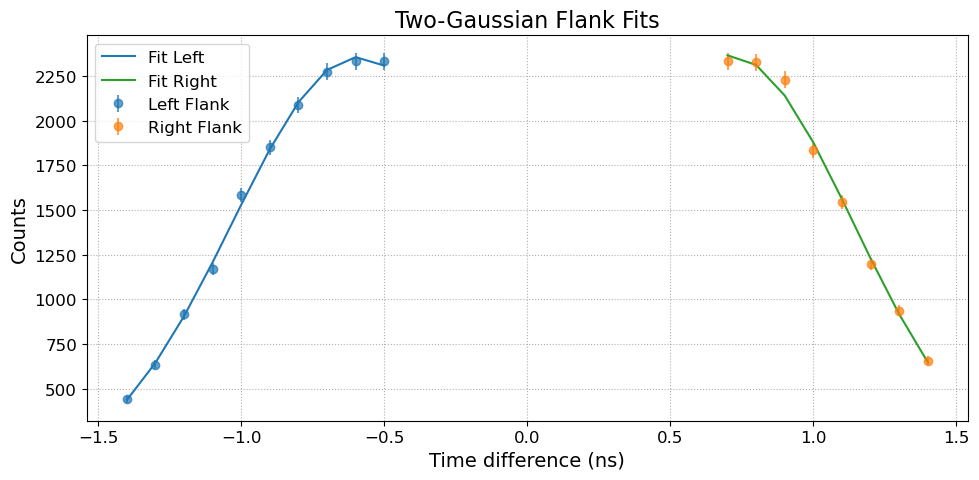

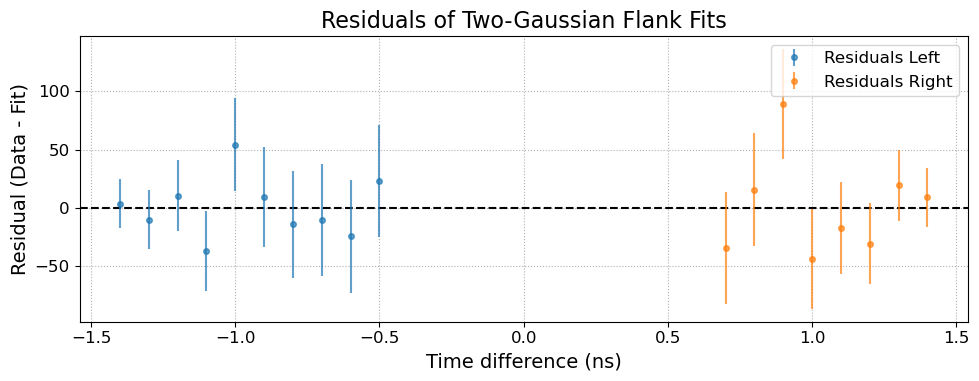

(0.4361553690977825, 0.009874452914844869)

In [40]:
# how to open a root file in python

with uproot.open("/Users/sidne/DarkLight 2025/output00049.root") as f:
    fileID = "t58ns_1458" # this is the nicest plot, start here then try t58ns_1458
    timeDiff = f["dltdc"][fileID].to_numpy()[0] #y data
    #t14 = f["dltdc"]["t14ns_1458"].to_numpy()[0]
    #t58 = f["dltdc"]["t58ns_1458"].to_numpy()[0]
    #t23 = f["dltdc"]["t23ns_2367"].to_numpy()[0]
    #t67 = f["dltdc"]["t67ns_2367"].to_numpy()[0]
    x_root = f["dltdc"][fileID].to_numpy()[1][0:-1] #x data
    
    timeDiff_firstHalf = timeDiff[0:int(len(timeDiff)/2)]
    timeDiff_lastHalf = timeDiff[int(len(timeDiff)/2):-1]

    
    #Store index where the data is 10% of the max value for that portion of data
    first10pmaxIndex = 0
    last10pmaxIndex = 0
    threshold = 0.15 #Proportion of the max we want to cut at (choose data greater than this proportion of the max)
    foundMax = 0 #Switch to be changed once we find the point crossing the threshold of the max of that part of the data
    i = 0
    j = 0

    while (foundMax == 0) and (i < len(timeDiff_firstHalf)):
        
        if timeDiff_firstHalf[i] > threshold*max(timeDiff_firstHalf):
            first10pmaxIndex = i
            foundMax = 1            
        i = i+1
        
    while (foundMax != 2) and (j < len(timeDiff_lastHalf)):
        
        if timeDiff_lastHalf[len(timeDiff_lastHalf) - 1 - j] > threshold*max(timeDiff_lastHalf):
            last10pmaxIndex = len(timeDiff_lastHalf) - 1 - j
            foundMax = 2            
        j = j+1
            
    #Cut data
    timeDiff_cut = timeDiff[first10pmaxIndex:len(timeDiff_firstHalf)+last10pmaxIndex]
    x_root_cut = x_root[first10pmaxIndex:len(timeDiff_firstHalf)+last10pmaxIndex]
    
    #Calculate y error bars
    y_err = []
    for i in range(len(timeDiff)):
        y_err.append(np.sqrt(timeDiff[i]))
        
    y_err_cut = []
    for i in range(len(timeDiff_cut)):
        y_err_cut.append(np.sqrt(timeDiff_cut[i]))
        
        
    # NEW FOR CHOPPING OFF THE TOP
    peakHeight = max(timeDiff_cut)
    countsChopped_cut = np.zeros(len(timeDiff_cut))
    countsChopped_cut.tolist()
    
    for i in range(len(timeDiff_cut)):
        if timeDiff_cut[i]>((1-threshold)*peakHeight):
            countsChopped_cut[i] = (1-threshold)*peakHeight
        
        else:
            countsChopped_cut[i] = timeDiff_cut[i]
                  
#plt.plot(x_root_cut,timeDiff_cut)


--- Two-Gaussian Flank Fit ---
Left  σ = 0.4832 ± 0.0138, χ²/ν = 1.68
Right σ = 0.5190 ± 0.0204, χ²/ν = 0.59

Average Timing Resolution: σ = 0.5011 ± 0.0123 ns


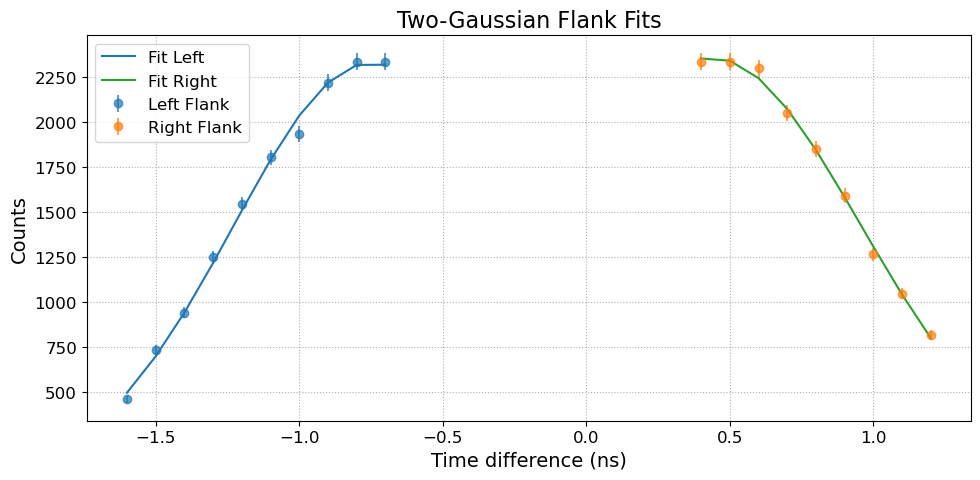

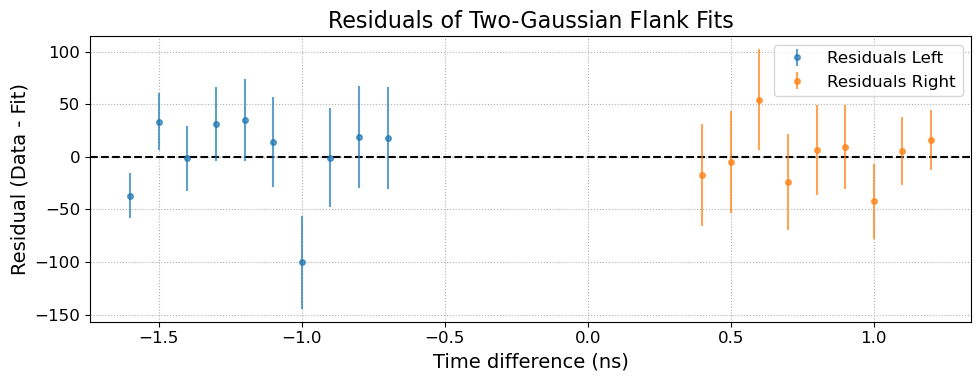

(0.5010815760909395, 0.012309594131043359)

In [41]:
flank_mask = get_flank_mask_slope_based(x_root_cut, countsChopped_cut, buffer_bins=1, slope_threshold_frac=0.05)
x_flank_g = x_root_cut[flank_mask]
y_flank_g = countsChopped_cut[flank_mask]

fit_two_flanks_gaussian(x_flank_g, y_flank_g)

In [42]:
# how to open a root file in python

with uproot.open("/Users/sidne/DarkLight 2025/output00049.root") as f:
    fileID = "t23ns_2367" # this is the nicest plot, start here then try t58ns_1458
    timeDiff = f["dltdc"][fileID].to_numpy()[0] #y data
    #t14 = f["dltdc"]["t14ns_1458"].to_numpy()[0]
    #t58 = f["dltdc"]["t58ns_1458"].to_numpy()[0]
    #t23 = f["dltdc"]["t23ns_2367"].to_numpy()[0]
    #t67 = f["dltdc"]["t67ns_2367"].to_numpy()[0]
    x_root = f["dltdc"][fileID].to_numpy()[1][0:-1] #x data
    
    timeDiff_firstHalf = timeDiff[0:int(len(timeDiff)/2)]
    timeDiff_lastHalf = timeDiff[int(len(timeDiff)/2):-1]

    
    #Store index where the data is 10% of the max value for that portion of data
    first10pmaxIndex = 0
    last10pmaxIndex = 0
    threshold = 0.15 #Proportion of the max we want to cut at (choose data greater than this proportion of the max)
    foundMax = 0 #Switch to be changed once we find the point crossing the threshold of the max of that part of the data
    i = 0
    j = 0

    while (foundMax == 0) and (i < len(timeDiff_firstHalf)):
        
        if timeDiff_firstHalf[i] > threshold*max(timeDiff_firstHalf):
            first10pmaxIndex = i
            foundMax = 1            
        i = i+1
        
    while (foundMax != 2) and (j < len(timeDiff_lastHalf)):
        
        if timeDiff_lastHalf[len(timeDiff_lastHalf) - 1 - j] > threshold*max(timeDiff_lastHalf):
            last10pmaxIndex = len(timeDiff_lastHalf) - 1 - j
            foundMax = 2            
        j = j+1
            
    #Cut data
    timeDiff_cut = timeDiff[first10pmaxIndex:len(timeDiff_firstHalf)+last10pmaxIndex]
    x_root_cut = x_root[first10pmaxIndex:len(timeDiff_firstHalf)+last10pmaxIndex]
    
    #Calculate y error bars
    y_err = []
    for i in range(len(timeDiff)):
        y_err.append(np.sqrt(timeDiff[i]))
        
    y_err_cut = []
    for i in range(len(timeDiff_cut)):
        y_err_cut.append(np.sqrt(timeDiff_cut[i]))
        
        
    # NEW FOR CHOPPING OFF THE TOP
    peakHeight = max(timeDiff_cut)
    countsChopped_cut = np.zeros(len(timeDiff_cut))
    countsChopped_cut.tolist()
    
    for i in range(len(timeDiff_cut)):
        if timeDiff_cut[i]>((1-threshold)*peakHeight):
            countsChopped_cut[i] = (1-threshold)*peakHeight
        
        else:
            countsChopped_cut[i] = timeDiff_cut[i]
                  
#plt.plot(x_root_cut,timeDiff_cut)

--- Two-Gaussian Flank Fit ---
Left  σ = 0.4360 ± 0.0133, χ²/ν = 0.70
Right σ = 0.4656 ± 0.0156, χ²/ν = 0.94

Average Timing Resolution: σ = 0.4508 ± 0.0103 ns


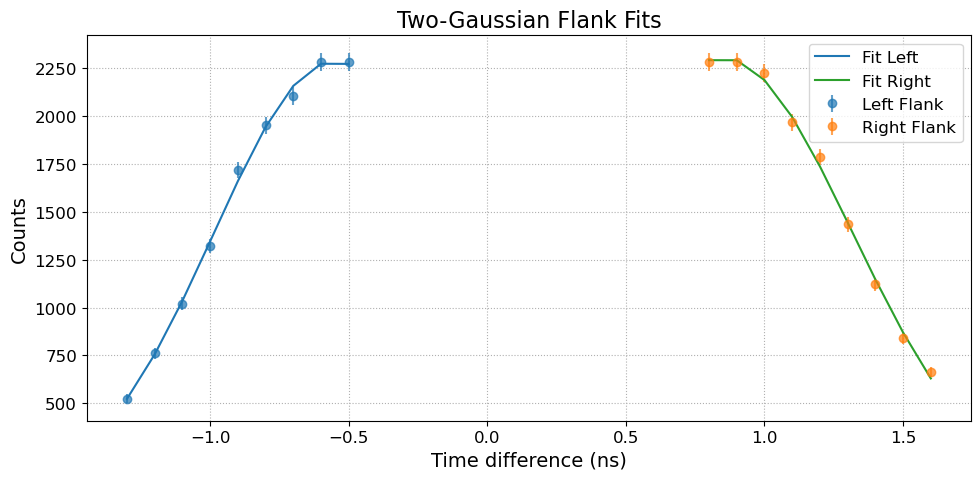

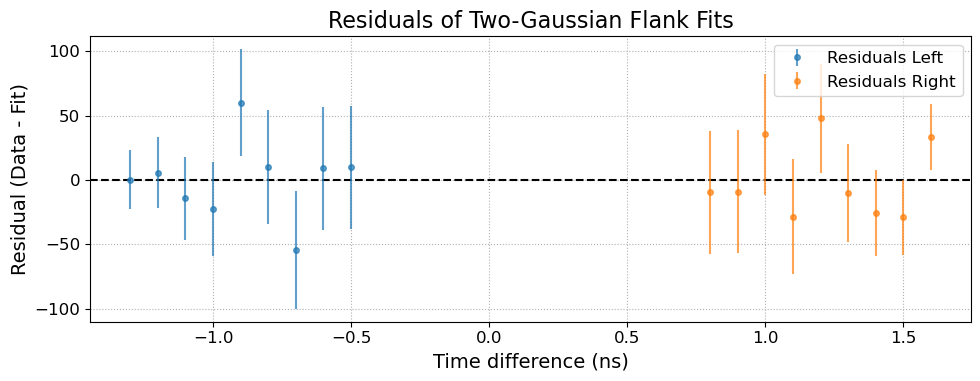

(0.4508171642884101, 0.010262081365074375)

In [43]:
flank_mask = get_flank_mask_slope_based(x_root_cut, countsChopped_cut, buffer_bins=1, slope_threshold_frac=0.05)
x_flank_g = x_root_cut[flank_mask]
y_flank_g = countsChopped_cut[flank_mask]

fit_two_flanks_gaussian(x_flank_g, y_flank_g)

In [44]:
# how to open a root file in python

with uproot.open("/Users/sidne/DarkLight 2025/output00049.root") as f:
    fileID = "t67ns_2367" # this is the nicest plot, start here then try t58ns_1458
    timeDiff = f["dltdc"][fileID].to_numpy()[0] #y data
    
    #t14 = f["dltdc"]["t14ns_1458"].to_numpy()[0]
    #t58 = f["dltdc"]["t58ns_1458"].to_numpy()[0]
    #t23 = f["dltdc"]["t23ns_2367"].to_numpy()[0]
    #t67 = f["dltdc"]["t67ns_2367"].to_numpy()[0]
    x_root = f["dltdc"][fileID].to_numpy()[1][0:-1] #x data
    
    timeDiff_firstHalf = timeDiff[0:int(len(timeDiff)/2)]
    timeDiff_lastHalf = timeDiff[int(len(timeDiff)/2):-1]

    
    #Store index where the data is 10% of the max value for that portion of data
    first10pmaxIndex = 0
    last10pmaxIndex = 0
    threshold = 0.15 #Proportion of the max we want to cut at (choose data greater than this proportion of the max)
    foundMax = 0 #Switch to be changed once we find the point crossing the threshold of the max of that part of the data
    i = 0
    j = 0

    while (foundMax == 0) and (i < len(timeDiff_firstHalf)):
        
        if timeDiff_firstHalf[i] > threshold*max(timeDiff_firstHalf):
            first10pmaxIndex = i
            foundMax = 1            
        i = i+1
        
    while (foundMax != 2) and (j < len(timeDiff_lastHalf)):
        
        if timeDiff_lastHalf[len(timeDiff_lastHalf) - 1 - j] > threshold*max(timeDiff_lastHalf):
            last10pmaxIndex = len(timeDiff_lastHalf) - 1 - j
            foundMax = 2            
        j = j+1
            
    #Cut data
    timeDiff_cut = timeDiff[first10pmaxIndex:len(timeDiff_firstHalf)+last10pmaxIndex]
    x_root_cut = x_root[first10pmaxIndex:len(timeDiff_firstHalf)+last10pmaxIndex]
    
    #Calculate y error bars
    y_err = []
    for i in range(len(timeDiff)):
        y_err.append(np.sqrt(timeDiff[i]))
        
    y_err_cut = []
    for i in range(len(timeDiff_cut)):
        y_err_cut.append(np.sqrt(timeDiff_cut[i]))
        
        
    # NEW FOR CHOPPING OFF THE TOP
    peakHeight = max(timeDiff_cut)
    countsChopped_cut = np.zeros(len(timeDiff_cut))
    countsChopped_cut.tolist()
    
    for i in range(len(timeDiff_cut)):
        if timeDiff_cut[i]>((1-threshold)*peakHeight):
            countsChopped_cut[i] = (1-threshold)*peakHeight
        
        else:
            countsChopped_cut[i] = timeDiff_cut[i]
                  
#plt.plot(x_root_cut,timeDiff_cut)

--- Two-Gaussian Flank Fit ---
Left  σ = 0.4319 ± 0.0131, χ²/ν = 0.77
Right σ = 0.5418 ± 0.0236, χ²/ν = 0.74

Average Timing Resolution: σ = 0.4868 ± 0.0135 ns


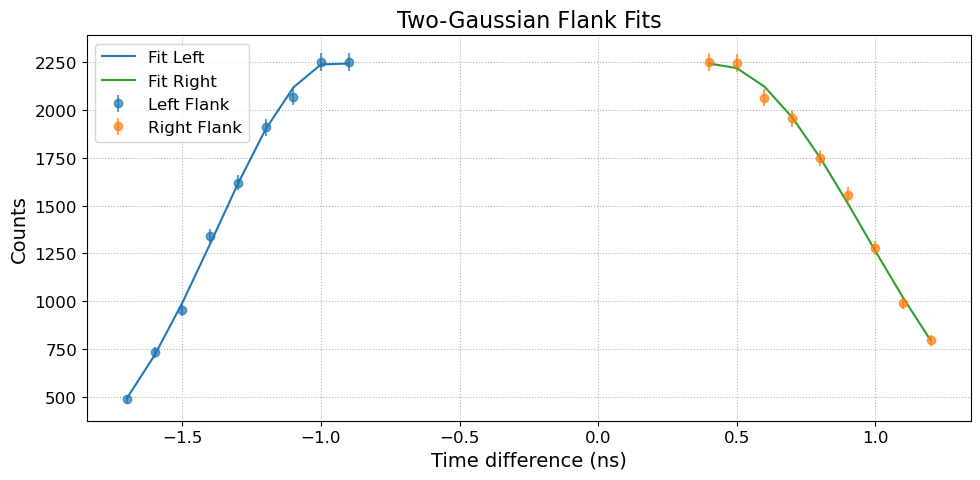

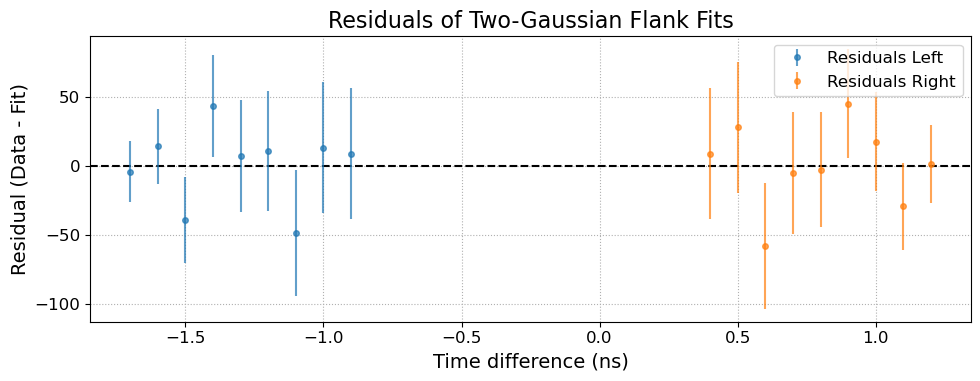

(0.486808627758561, 0.013500391547413542)

In [45]:
flank_mask = get_flank_mask_slope_based(x_root_cut, countsChopped_cut, buffer_bins=1, slope_threshold_frac=0.05)
x_flank_g = x_root_cut[flank_mask]
y_flank_g = countsChopped_cut[flank_mask]

fit_two_flanks_gaussian(x_flank_g, y_flank_g)

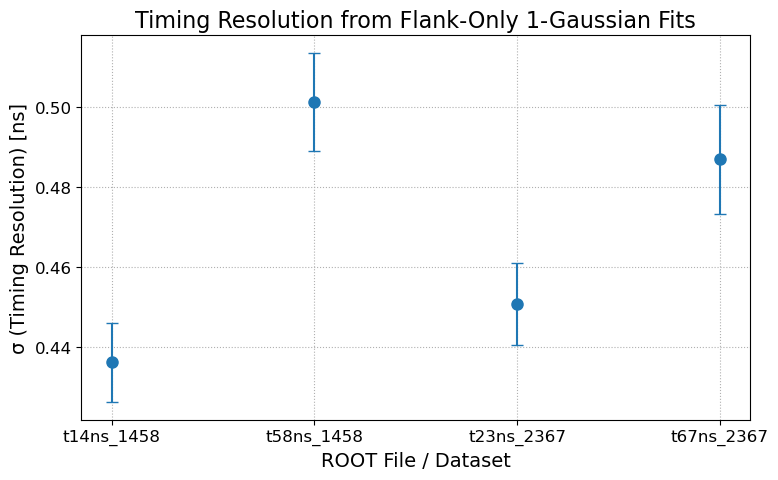

In [47]:


file_names = ["t14ns_1458", "t58ns_1458", "t23ns_2367", "t67ns_2367"]
timing_sigmas = [0.4362, 0.5011, 0.4508, 0.4868]  # from flank fits



timing_errors = [0.0099, 0.0123, 0.0103, 0.0135]  # same length as timing_sigmas

plt.figure(figsize=(8, 5))

# Scatter with vertical error bars only, no lines between points
plt.errorbar(file_names, timing_sigmas, yerr=timing_errors, fmt='o',
             markersize=8, capsize=4, elinewidth=1.5, color='tab:blue')

# Labels and formatting
plt.ylabel("σ (Timing Resolution) [ns]", fontsize=14)
plt.xlabel("ROOT File / Dataset", fontsize=14)
plt.title("Timing Resolution from Flank-Only 1-Gaussian Fits", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle=':')

plt.tight_layout()
plt.show()


In [64]:
def auto_fit_two_flanks_gaussian(
    x_cut,
    y_cut,
    initial_thresh=0.05,
    buffer_bins=1,
    max_iterations=10,
    verbose=True
):
    """
    Try different slope thresholds to find the best 2-flank Gaussian fit.
    Returns best (popt1, popt2, sigma_avg, chi2red_total, slope_threshold_used)
    """
    slope_thresh = initial_thresh
    best_result = None
    best_chi2red = np.inf

    for _ in range(max_iterations):
        flank_mask = get_flank_mask_slope_based(x_cut, y_cut, buffer_bins, slope_thresh)
        x_flank = x_cut[flank_mask]
        y_flank = y_cut[flank_mask]

        if len(x_flank) < 6:
            if verbose:
                print(f"[!] Too few flank points at slope_thresh={slope_thresh:.3f}")
            slope_thresh += 0.01
            continue

        midpoint = np.average(x_flank, weights=y_flank)
        left_mask = x_flank < midpoint
        right_mask = x_flank >= midpoint

        if np.sum(left_mask) < 3 or np.sum(right_mask) < 3:
            if verbose:
                print(f"[!] Too few points on one side at slope_thresh={slope_thresh:.3f}")
            slope_thresh += 0.01
            continue

        try:
            popt1, _, _, chi2_1, _, _, _, _ = fit_single_gaussian(x_flank[left_mask], y_flank[left_mask])
            popt2, _, _, chi2_2, _, _, _, _ = fit_single_gaussian(x_flank[right_mask], y_flank[right_mask])
            chi2_comb = chi2_1 + chi2_2
            dof = (len(x_flank[left_mask]) + len(x_flank[right_mask])) - 6
            chi2red_comb = chi2_comb / dof

            if verbose:
                print(f"[✓] slope_thresh = {slope_thresh:.3f} → χ²/ν = {chi2red_comb:.2f}")

            if chi2red_comb < best_chi2red:
                sigma_avg = 0.5 * (popt1[2] + popt2[2])
                best_result = (popt1, popt2, sigma_avg, chi2red_comb, slope_thresh)
                best_chi2red = chi2red_comb

        except Exception as e:
            if verbose:
                print(f"[!] Fit error at slope_thresh={slope_thresh:.3f}: {e}")

        slope_thresh += 0.01

    if best_result is not None:
        if verbose:
            print(f"[✓] Best result: χ²/ν = {best_result[3]:.2f} at slope_thresh = {best_result[4]:.3f}")
        return best_result
    else:
        if verbose:
            print("[X] All fits failed.")
        return None, None, None, None, None



=== Processing: dltdc16_sc01_t_01_09_ns_cut_twc ===
[✓] slope_thresh = 0.025 → χ²/ν = 506.79
[✓] slope_thresh = 0.035 → χ²/ν = 521.20
[✓] slope_thresh = 0.045 → χ²/ν = 509.98
[✓] slope_thresh = 0.055 → χ²/ν = 61.16
[✓] slope_thresh = 0.065 → χ²/ν = 61.16
[✓] slope_thresh = 0.075 → χ²/ν = 61.16
[✓] slope_thresh = 0.085 → χ²/ν = 61.16
[✓] slope_thresh = 0.095 → χ²/ν = 61.16
[✓] slope_thresh = 0.105 → χ²/ν = 30.96
[✓] slope_thresh = 0.115 → χ²/ν = 30.96
[✓] slope_thresh = 0.125 → χ²/ν = 22.06
[✓] slope_thresh = 0.135 → χ²/ν = 22.06
[✓] slope_thresh = 0.145 → χ²/ν = 22.06
[✓] slope_thresh = 0.155 → χ²/ν = 22.06
[✓] slope_thresh = 0.165 → χ²/ν = 22.06
[✓] slope_thresh = 0.175 → χ²/ν = 22.06
[✓] slope_thresh = 0.185 → χ²/ν = 22.06
[✓] slope_thresh = 0.195 → χ²/ν = 22.06
[✓] slope_thresh = 0.205 → χ²/ν = 22.06
[✓] slope_thresh = 0.215 → χ²/ν = 22.06
[✓] slope_thresh = 0.225 → χ²/ν = 22.06
[✓] slope_thresh = 0.235 → χ²/ν = 22.06
[✓] slope_thresh = 0.245 → χ²/ν = 22.06
[✓] slope_thresh = 0.255

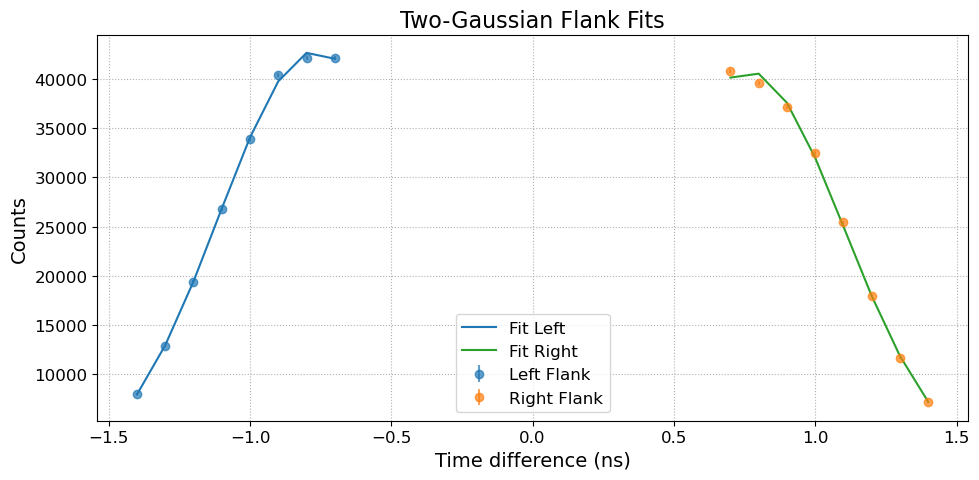

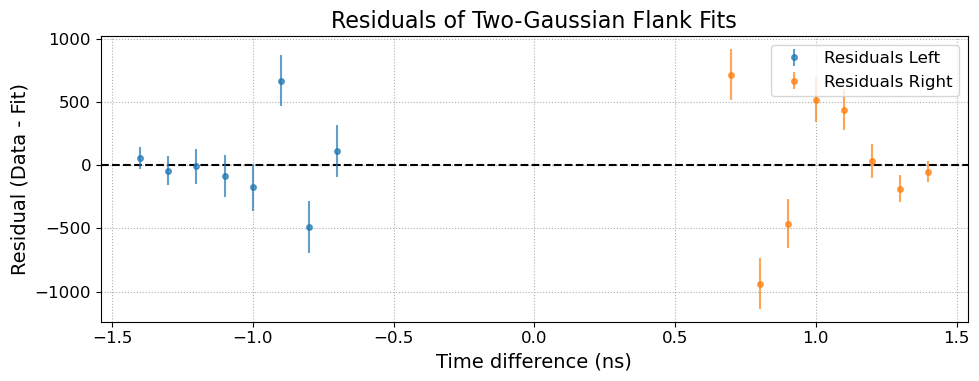


=== Processing: dltdc16_sc02_t_02_10_ns_cut_twc ===
[✓] slope_thresh = 0.025 → χ²/ν = 257.34
[✓] slope_thresh = 0.035 → χ²/ν = 257.34
[✓] slope_thresh = 0.045 → χ²/ν = 257.34
[✓] slope_thresh = 0.055 → χ²/ν = 257.34
[✓] slope_thresh = 0.065 → χ²/ν = 257.34
[✓] slope_thresh = 0.075 → χ²/ν = 257.34
[✓] slope_thresh = 0.085 → χ²/ν = 234.91
[✓] slope_thresh = 0.095 → χ²/ν = 234.91
[✓] slope_thresh = 0.105 → χ²/ν = 234.91
[✓] slope_thresh = 0.115 → χ²/ν = 234.91
[✓] slope_thresh = 0.125 → χ²/ν = 234.91
[✓] slope_thresh = 0.135 → χ²/ν = 234.91
[✓] slope_thresh = 0.145 → χ²/ν = 234.91
[✓] slope_thresh = 0.155 → χ²/ν = 234.91
[✓] slope_thresh = 0.165 → χ²/ν = 268.50
[✓] slope_thresh = 0.175 → χ²/ν = 268.50
[✓] slope_thresh = 0.185 → χ²/ν = 268.50
[✓] slope_thresh = 0.195 → χ²/ν = 8.65
[✓] slope_thresh = 0.205 → χ²/ν = 8.65
[✓] slope_thresh = 0.215 → χ²/ν = 8.65
[✓] slope_thresh = 0.225 → χ²/ν = 8.65
[✓] slope_thresh = 0.235 → χ²/ν = 8.65
[✓] slope_thresh = 0.245 → χ²/ν = 8.65
[✓] slope_thresh

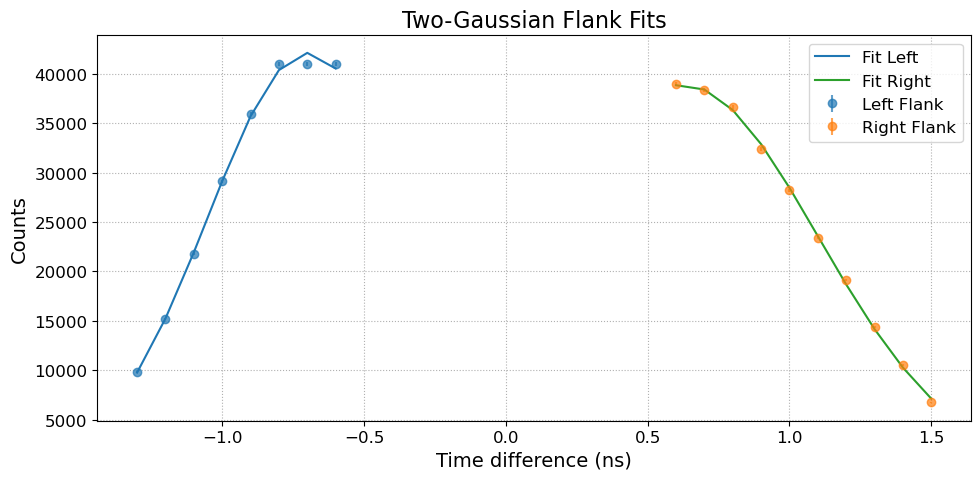

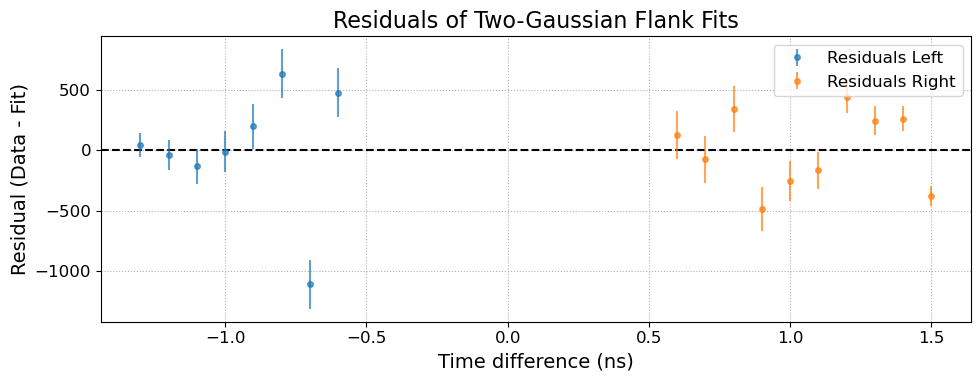


=== Processing: dltdc16_sc03_t_03_11_ns_cut_twc ===
[✓] slope_thresh = 0.025 → χ²/ν = 33.73
[✓] slope_thresh = 0.035 → χ²/ν = 33.73
[✓] slope_thresh = 0.045 → χ²/ν = 25.88
[✓] slope_thresh = 0.055 → χ²/ν = 25.88
[✓] slope_thresh = 0.065 → χ²/ν = 25.88
[✓] slope_thresh = 0.075 → χ²/ν = 25.88
[✓] slope_thresh = 0.085 → χ²/ν = 25.88
[✓] slope_thresh = 0.095 → χ²/ν = 25.88
[✓] slope_thresh = 0.105 → χ²/ν = 25.88
[✓] slope_thresh = 0.115 → χ²/ν = 25.88
[✓] slope_thresh = 0.125 → χ²/ν = 25.88
[✓] slope_thresh = 0.135 → χ²/ν = 25.88
[✓] slope_thresh = 0.145 → χ²/ν = 25.88
[✓] slope_thresh = 0.155 → χ²/ν = 25.88
[✓] slope_thresh = 0.165 → χ²/ν = 20.41
[✓] slope_thresh = 0.175 → χ²/ν = 20.41
[✓] slope_thresh = 0.185 → χ²/ν = 20.41
[✓] slope_thresh = 0.195 → χ²/ν = 14.02
[✓] slope_thresh = 0.205 → χ²/ν = 14.02
[✓] slope_thresh = 0.215 → χ²/ν = 14.02
[✓] slope_thresh = 0.225 → χ²/ν = 14.02
[✓] slope_thresh = 0.235 → χ²/ν = 14.02
[✓] slope_thresh = 0.245 → χ²/ν = 14.02
[✓] slope_thresh = 0.255 → 

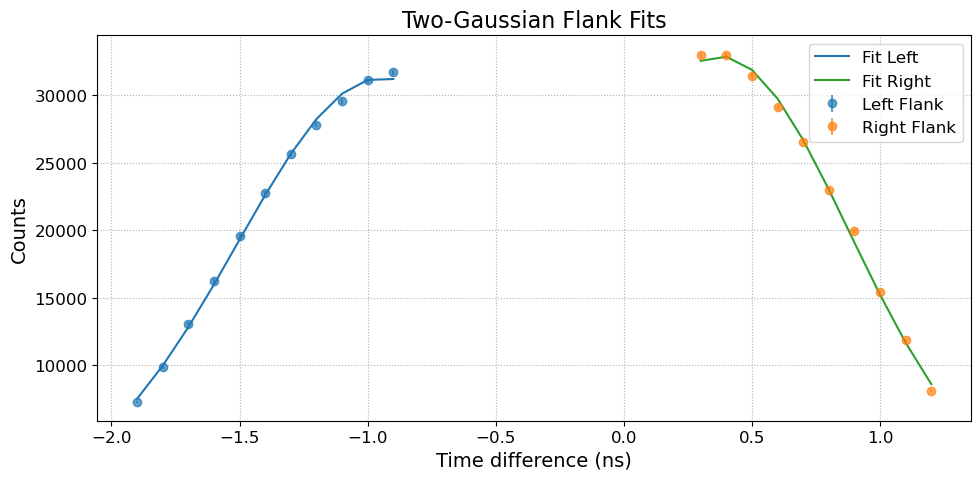

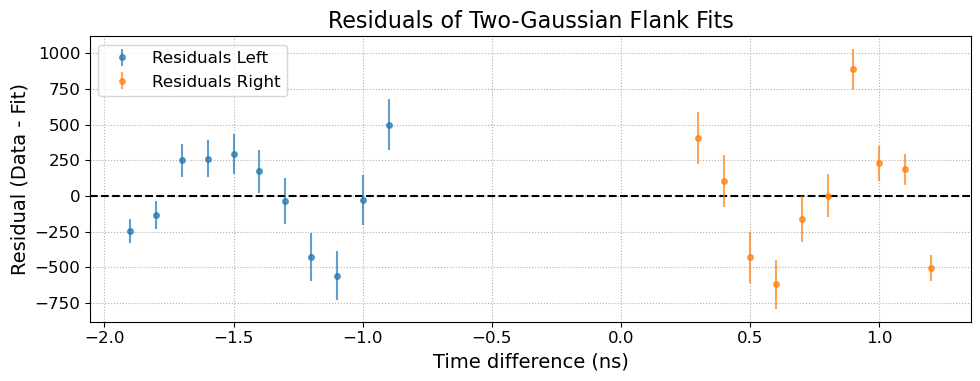


=== Processing: dltdc16_sc04_t_04_12_ns_cut_twc ===
[✓] slope_thresh = 0.025 → χ²/ν = 461.61
[✓] slope_thresh = 0.035 → χ²/ν = 461.61
[✓] slope_thresh = 0.045 → χ²/ν = 461.61
[✓] slope_thresh = 0.055 → χ²/ν = 461.61
[✓] slope_thresh = 0.065 → χ²/ν = 461.61
[✓] slope_thresh = 0.075 → χ²/ν = 441.24
[✓] slope_thresh = 0.085 → χ²/ν = 441.24
[✓] slope_thresh = 0.095 → χ²/ν = 441.24
[✓] slope_thresh = 0.105 → χ²/ν = 392.93
[✓] slope_thresh = 0.115 → χ²/ν = 392.93
[✓] slope_thresh = 0.125 → χ²/ν = 392.93
[✓] slope_thresh = 0.135 → χ²/ν = 394.62
[✓] slope_thresh = 0.145 → χ²/ν = 394.62
[✓] slope_thresh = 0.155 → χ²/ν = 394.62
[✓] slope_thresh = 0.165 → χ²/ν = 394.62
[✓] slope_thresh = 0.175 → χ²/ν = 394.62
[✓] slope_thresh = 0.185 → χ²/ν = 17.15
[✓] slope_thresh = 0.195 → χ²/ν = 7.37
[✓] slope_thresh = 0.205 → χ²/ν = 7.37
[✓] slope_thresh = 0.215 → χ²/ν = 7.37
[✓] slope_thresh = 0.225 → χ²/ν = 7.37
[✓] slope_thresh = 0.235 → χ²/ν = 7.37
[✓] slope_thresh = 0.245 → χ²/ν = 7.37
[✓] slope_thresh 

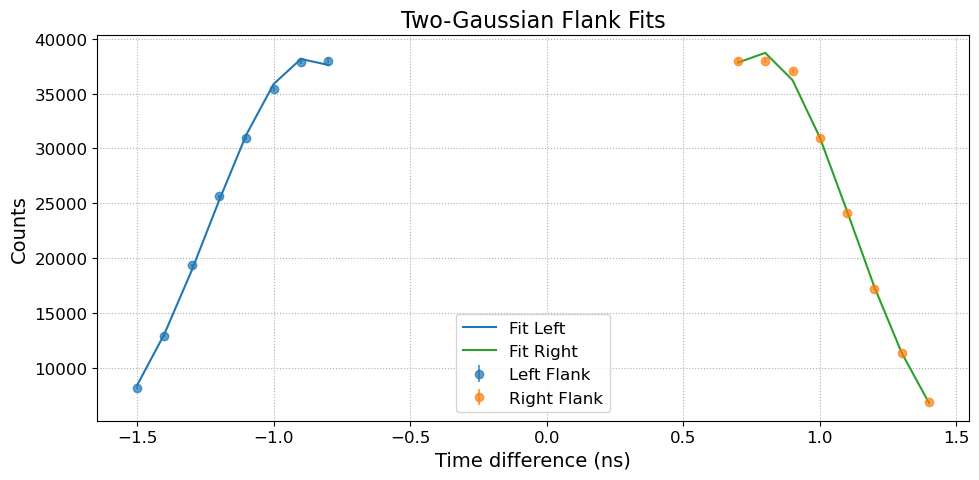

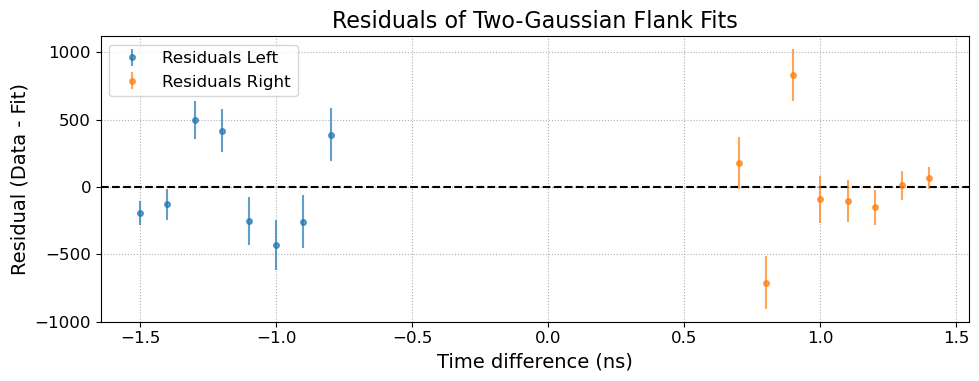


=== Processing: dltdc16_sc09_t_17_25_ns_cut_twc ===
[✓] slope_thresh = 0.025 → χ²/ν = 369.09
[✓] slope_thresh = 0.035 → χ²/ν = 352.05
[✓] slope_thresh = 0.045 → χ²/ν = 177.79
[✓] slope_thresh = 0.055 → χ²/ν = 141.46
[✓] slope_thresh = 0.065 → χ²/ν = 141.46
[✓] slope_thresh = 0.075 → χ²/ν = 141.46
[✓] slope_thresh = 0.085 → χ²/ν = 141.46
[✓] slope_thresh = 0.095 → χ²/ν = 141.46
[✓] slope_thresh = 0.105 → χ²/ν = 104.18
[✓] slope_thresh = 0.115 → χ²/ν = 104.18
[✓] slope_thresh = 0.125 → χ²/ν = 104.18
[✓] slope_thresh = 0.135 → χ²/ν = 65.75
[✓] slope_thresh = 0.145 → χ²/ν = 65.75
[✓] slope_thresh = 0.155 → χ²/ν = 36.62
[✓] slope_thresh = 0.165 → χ²/ν = 36.62
[✓] slope_thresh = 0.175 → χ²/ν = 31.14
[✓] slope_thresh = 0.185 → χ²/ν = 31.14
[✓] slope_thresh = 0.195 → χ²/ν = 31.14
[✓] slope_thresh = 0.205 → χ²/ν = 31.14
[✓] slope_thresh = 0.215 → χ²/ν = 31.14
[✓] slope_thresh = 0.225 → χ²/ν = 10.06
[✓] slope_thresh = 0.235 → χ²/ν = 10.06
[✓] slope_thresh = 0.245 → χ²/ν = 10.06
[✓] slope_thresh

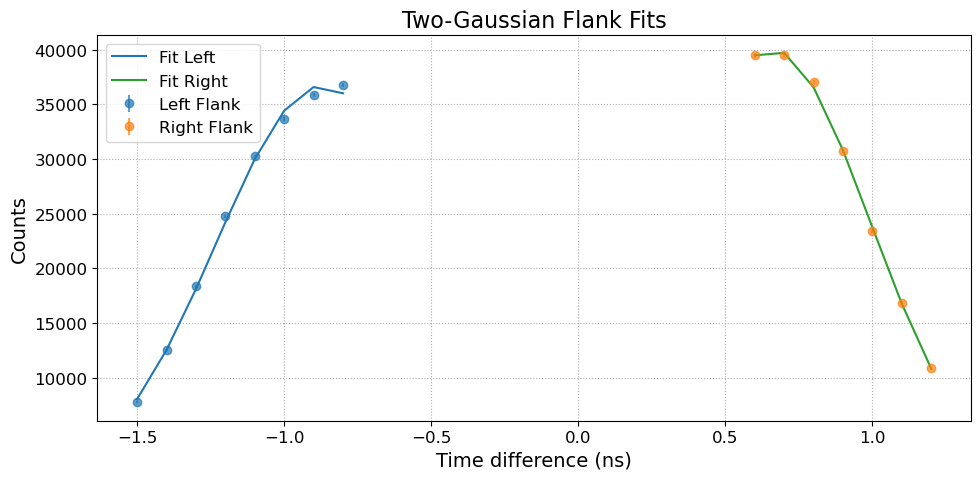

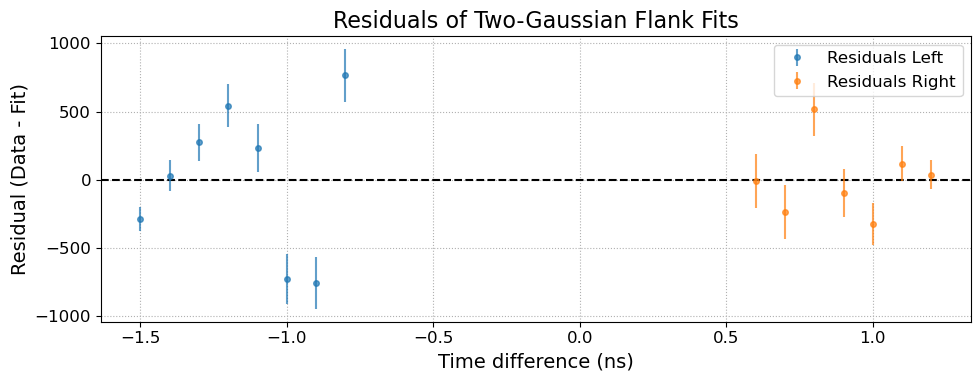


=== Processing: dltdc16_sc10_t_18_26_ns_cut_twc ===
[✓] slope_thresh = 0.025 → χ²/ν = 573.60
[✓] slope_thresh = 0.035 → χ²/ν = 573.60
[✓] slope_thresh = 0.045 → χ²/ν = 573.60
[✓] slope_thresh = 0.055 → χ²/ν = 578.21
[✓] slope_thresh = 0.065 → χ²/ν = 578.21
[✓] slope_thresh = 0.075 → χ²/ν = 563.60
[✓] slope_thresh = 0.085 → χ²/ν = 563.60
[✓] slope_thresh = 0.095 → χ²/ν = 559.13
[✓] slope_thresh = 0.105 → χ²/ν = 559.13
[✓] slope_thresh = 0.115 → χ²/ν = 559.13
[✓] slope_thresh = 0.125 → χ²/ν = 559.13
[✓] slope_thresh = 0.135 → χ²/ν = 559.13
[✓] slope_thresh = 0.145 → χ²/ν = 613.53
[✓] slope_thresh = 0.155 → χ²/ν = 613.53
[✓] slope_thresh = 0.165 → χ²/ν = 613.53
[✓] slope_thresh = 0.175 → χ²/ν = 24.28
[✓] slope_thresh = 0.185 → χ²/ν = 24.28
[✓] slope_thresh = 0.195 → χ²/ν = 24.28
[✓] slope_thresh = 0.205 → χ²/ν = 24.28
[✓] slope_thresh = 0.215 → χ²/ν = 24.28
[✓] slope_thresh = 0.225 → χ²/ν = 24.28
[✓] slope_thresh = 0.235 → χ²/ν = 24.28
[✓] slope_thresh = 0.245 → χ²/ν = 24.28
[✓] slope_th

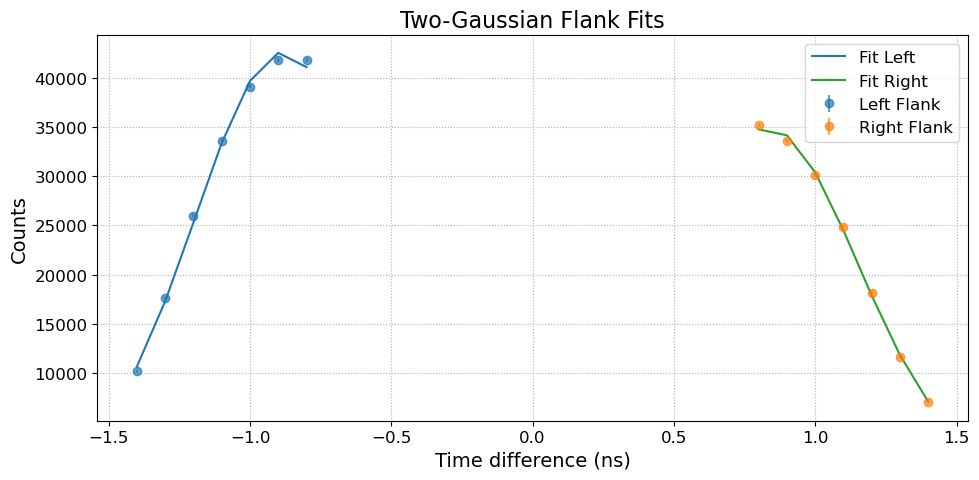

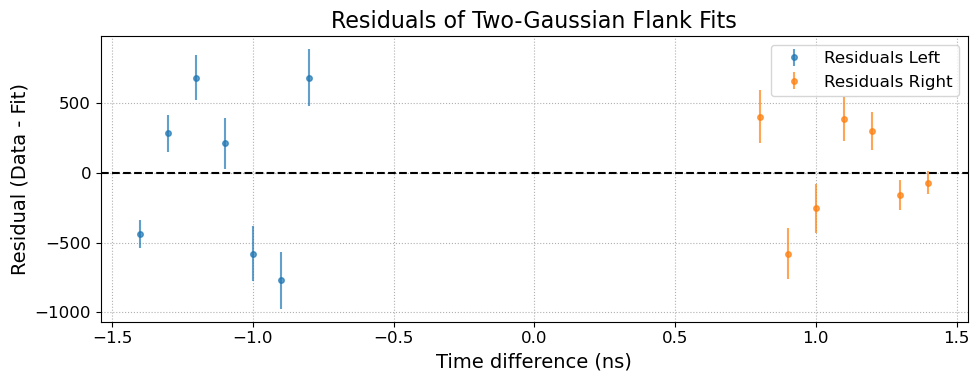

In [73]:


histogram_names = [
    "dltdc16_sc01_t_01_09_ns_cut_twc",
    "dltdc16_sc02_t_02_10_ns_cut_twc",
    "dltdc16_sc03_t_03_11_ns_cut_twc",
    "dltdc16_sc04_t_04_12_ns_cut_twc",
    "dltdc16_sc09_t_17_25_ns_cut_twc",
    "dltdc16_sc10_t_18_26_ns_cut_twc",
]
buffer_bins=2
with uproot.open("/Users/sidne/DarkLight 2025/output00449.root") as f:
    for fileID in histogram_names:
        print(f"\n=== Processing: {fileID} ===")
        timeDiff = f["dltdc16"][fileID].to_numpy()[0]
        x_root = f["dltdc16"][fileID].to_numpy()[1][:-1]

        half = len(timeDiff) // 2
        threshold = 0.15
        first = next(i for i, y in enumerate(timeDiff[:half]) if y > threshold * max(timeDiff[:half]))
        last = next(i for i, y in enumerate(timeDiff[half:][::-1]) if y > threshold * max(timeDiff[half:]))
        last = len(timeDiff) - 1 - last

        x_root_cut = x_root[first:last + 1]
        timeDiff_cut = timeDiff[first:last + 1]
        y_err_cut = np.sqrt(np.clip(timeDiff_cut, 1, None))
        peakHeight = max(timeDiff_cut)
        countsChopped_cut = np.minimum(timeDiff_cut, (1 - threshold) * peakHeight)

        result = auto_fit_two_flanks_gaussian(
            x_root_cut,
            countsChopped_cut,
            initial_thresh=0.025,
            buffer_bins=buffer_bins,
            max_iterations=30,
            verbose=True
        )

        if result[0] is not None:
            _, _, sigma_avg, chi2red, best_thresh = result
            print(f"✅ Best result for {fileID}:")
            print(f"   σ = {sigma_avg:.4f} ns")
            print(f"   χ²/ν = {chi2red:.2f}")
            print(f"   slope threshold = {best_thresh:.3f}")

            # Now rerun the full Gaussian flank fit with the best slope threshold found
            flank_mask = get_flank_mask_slope_based(
                x_root_cut, countsChopped_cut,
                buffer_bins=buffer_bins,
                slope_threshold_frac=best_thresh
            )
            x_flank_g = x_root_cut[flank_mask]
            y_flank_g = countsChopped_cut[flank_mask]
            fit_two_flanks_gaussian(x_flank_g, y_flank_g)
        else:
            print(f"❌ No acceptable fit found for {fileID}")
